# Проект: Предсказание рисков сердечного приступа

Ссылка на проект в GitHub: <br>
<a href=https://github.com/Ckomopox80/Project_month_part_one>https://github.com/Ckomopox80/Project_month_part_one</a>

## Вводная часть

### Описание проекта
В проекте разработана модель для предсказания риска сердечного приступа, используя данные пациентов, такие как возраст, привычки, состояние здоровья и результаты анализа крови, а также реализовано приложение на FastAPI для получения предсказаний по пользовательскому запросу.

Общая информация и цель проекта:
* В проекте используется датасет из открытого источника.
* Разработана модель машинного обучения.
* Подготовлена библиотека и интерфейс для предсказания на тестовой выборке.

### Задачи проекта
В ходе работы над проектом решены следующие задачи:
* Исследование датасета, поиск дополнительной информации для лучшего понимания природы данных.
* Предобработка данных. В данных могут быть бесполезные признаки, сильно скорелированные признаки а также косвенные утечки целевого признака.
* Обучение моделией и выбор лучшей модели и ее параметров.
* Предсказания на тестовой выборке. Файл предсказаний в csv формате содержит 2 столбца: “id” и “prediction”. 
* Написан инструмента для тестирования на FastAPI.
* Оформлена документация.

### Описание исходных данных

Описание признаков для  модели

Демографические и социальные признаки
- Age (Возраст) — количество полных лет пациента
- Gender (Пол) — мужской/женский
- Income (Доход) — уровень финансового благосостояния
- id (Идентификатор) — уникальный номер записи

Антропометрические показатели
- BMI (Индекс массы тела) — соотношение веса и роста
- Obesity (Ожирение) — наличие/отсутствие ожирения
- Sedentary Hours Per Day (Часы малоподвижности в день) — время, проведенное в сидячем положении
- Sleep Hours Per Day (Часы сна в день) — продолжительность ночного сна

Физиологические показатели
- Cholesterol (Холестерин) — уровень холестерина в крови
- Triglycerides (Триглицериды) — уровень триглицеридов в крови
- Blood sugar (Уровень сахара) — концентрация глюкозы в крови
- Systolic blood pressure (Систолическое давление) — верхнее давление
- Diastolic blood pressure (Диастолическое давление) — нижнее давление
- Heart rate (Пульс) — частота сердечных сокращений
- CK-MB — маркер повреждения сердечной мышцы
- Troponin — белок, показатель повреждения миокарда

Образ жизни
- Smoking (Курение) — наличие/отсутствие привычки к курению
- Alcohol Consumption (Употребление алкоголя) — частота и количество употребления
- Exercise Hours Per Week (Часы физических упражнений в неделю)
- Physical Activity Days Per Week (Дни физической активности в неделю)
- Diet (Питание) — тип и качество питания
- Stress Level (Уровень стресса) — субъективная оценка стресса

Медицинские показатели и анамнез
- Diabetes (Диабет) — наличие/отсутствие диабета
- Family History (Семейный анамнез) — наличие сердечно-сосудистых заболеваний у родственников
- Previous Heart Problems (Предыдущие проблемы с сердцем) — наличие сердечно-сосудистых заболеваний в анамнезе
- Medication Use (Прием лекарств) — использование медикаментов
- Heart Attack Risk (Binary) (Риск инфаркта, бинарный) — целевая переменная, указывающая на риск инфаркта

Взаимосвязи признаков
- BMI тесно связан с Obesity
- Exercise Hours Per Week и Physical Activity Days Per Week связаны с Sedentary Hours Per Day
- Diet влияет на Cholesterol, Triglycerides и Blood sugar
- Stress Level может влиять на Heart rate и Blood pressure
- Medication Use часто связана с Diabetes, Previous Heart Problems

### Используемая метрика оценки качества и сравнения моделей
В ходе анализа выбрана метрика оценки качества модели, проведено сравнение моделей и выбрана лучшая

### Стек:

- Python
- Pandas
- numpy
- Scikitlearn
- CatBoost
- FastAPI
- HTML

## Установка пакетов, Импорт библиотек, настройки, константы

### Установим отсутствуещие в окружении `practicum` пакеты (опционально)

In [9]:
#!pip install -q -U scikit-learn==1.5.2
#!pip install -q shap
#!pip install -q optuna
#!pip install -q optuna-integration
#!pip install -q phik
#!pip install -q imbalanced-learn
#!pip install -U catboost

### Импорт библиотек

In [ ]:
import os
import gc
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns

from joblib import Parallel, delayed
import multiprocessing

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, 
    StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder)

from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score, accuracy_score, make_scorer

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

### Настройки по умолчанию

In [11]:
# Применим настройку формата чисел с разделителем
pd.options.display.float_format = '{:_.4f}'.format
# установим размер графиков по умолчанию
plt.rcParams["figure.figsize"] = (20, 15) 
# Установка опции для отображения максимальной ширины столбца
pd.set_option('display.max_colwidth', None)
# Установка опции для отображения всех столбцов
pd.set_option('display.max_columns', None)

### Константы

In [12]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка и подготовка данных
### Загружаем данные из файлов:
`heart_train.csv`
`heart_test.csv`

In [13]:
# Создаем переменные с датафреймами датафрей проверяем три источника данных
try:
    if os.path.exists('/datasets/heart_train.csv'):
        df_heart_train = pd.read_csv('/datasets/heart_train.csv')
        df_heart_test = pd.read_csv('/datasets/heart_test.csv')
    elif os.path.exists('datasets/heart_train.csv'):
        df_heart_train = pd.read_csv('datasets/heart_train.csv')
        df_heart_test = pd.read_csv('datasets/heart_test.csv')
    else:
        df_heart_train = pd.read_csv('heart_train.csv')
        df_heart_test = pd.read_csv('heart_test.csv')
        
except FileNotFoundError:
    print("Ошибка: один или оба файла не найдены!")

### Обзор данных 

In [14]:
# функция вывода первых 5 строк датафрейма и информации о нем.
def head_info(df, rows=5):
    print(f'Первые {rows} строк и информация по датафрейму {df.attrs["name"]}: \n')
    display(df.head(rows))
    df.info()
    print()

In [15]:
df_names = {
    'df_heart_train': df_heart_train,
    'df_heart_test': df_heart_test
}
for name, df in df_names.items():
    df.attrs['name'] = name

In [16]:
dfs_train_test= [
    df_heart_train,
    df_heart_test
]

In [17]:
for df in dfs_train_test:
    head_info(df, 10)

Первые 10 строк и информация по датафрейму df_heart_train: 



,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.3596,0.7321,0.0742,1.0000,1.0000,1.0000,1.0000,1.0000,0.5355,1,1.0000,0.0000,8.0000,0.2257,0.1059,0.4592,0.9792,3.0000,0.3333,0.0000,0.2270,0.0482,0.0365,Male,0.2129,0.7093,2664
1,1,0.2022,0.3250,0.0477,1.0000,1.0000,0.0000,0.0000,1.0000,0.0687,2,1.0000,0.0000,9.0000,0.2899,0.1642,0.1171,0.5156,3.0000,0.8333,0.0000,0.1502,0.0176,0.0002,Female,0.4129,0.5698,9287
2,2,0.6067,0.8607,0.0559,1.0000,0.0000,1.0000,1.0000,1.0000,0.9440,2,1.0000,1.0000,6.0000,0.5501,0.5987,0.3736,0.0130,2.0000,1.0000,0.0000,0.2270,0.0482,0.0365,Female,0.2387,0.2209,5379
3,3,0.7303,0.0071,0.0532,0.0000,0.0000,1.0000,0.0000,1.0000,0.6970,0,0.0000,1.0000,3.0000,0.3310,0.0776,0.0497,0.1312,0.0000,0.3333,1.0000,0.2270,0.0482,0.0365,Female,0.3484,0.2674,8222
4,4,0.7753,0.7571,0.0220,0.0000,0.0000,1.0000,0.0000,1.0000,0.4129,1,0.0000,0.0000,8.0000,0.5246,0.3420,0.8304,0.0701,5.0000,1.0000,1.0000,0.2270,0.0482,0.0365,Male,0.6194,0.4419,4047
5,5,0.1685,0.7643,0.0577,0.0000,1.0000,1.0000,1.0000,1.0000,0.0827,1,1.0000,0.0000,7.0000,0.5583,0.6408,0.1106,0.2390,6.0000,0.8333,0.0000,0.2270,0.0482,0.0365,Male,0.4645,0.4186,5817
6,6,0.4831,0.0214,0.0367,1.0000,0.0000,1.0000,0.0000,1.0000,0.5402,2,0.0000,1.0000,9.0000,0.8276,0.7746,0.0737,0.0727,5.0000,0.0000,1.0000,0.2312,0.0089,0.0003,Male,0.3613,0.5698,5580
7,7,0.2360,0.9393,0.0816,1.0000,0.0000,1.0000,0.0000,1.0000,0.2908,2,0.0000,1.0000,7.0000,0.2253,0.9994,0.0015,0.1805,4.0000,0.0000,0.0000,0.2270,0.0482,0.0365,Male,0.6903,0.6395,4963
8,8,0.6854,0.3179,0.0394,0.0000,0.0000,1.0000,0.0000,0.0000,0.8032,0,1.0000,1.0000,3.0000,0.8282,0.1422,0.0931,0.9909,6.0000,0.1667,1.0000,0.1265,0.0023,0.0072,Male,0.6645,0.6163,4521
9,9,0.2135,0.7964,0.0770,1.0000,1.0000,1.0000,1.0000,0.0000,0.5070,1,0.0000,0.0000,7.0000,0.6930,0.8210,0.1454,0.1714,3.0000,1.0000,0.0000,0.2270,0.0482,0.0365,Male,0.6516,0.7209,2455


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medication Use      

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.4944,0.2643,0.0623,0.0000,1.0000,1.0000,1.0000,1.0000,0.3616,2,0.0000,0.0000,8.0000,0.1944,0.5878,0.2835,0.3065,1.0000,0.3333,0.2270,0.0482,0.0365,Male,0.2839,0.3721,7746
1,1,0.2247,0.9536,0.0825,1.0000,0.0000,0.0000,1.0000,0.0000,0.9965,2,1.0000,1.0000,5.0000,0.3299,0.6029,0.4670,0.0870,0.0000,0.1667,0.2270,0.0482,0.0365,Female,0.7032,0.4419,4202
2,2,0.6292,0.0929,0.0642,0.0000,1.0000,1.0000,1.0000,0.0000,0.9956,0,0.0000,0.0000,10.0000,0.7801,0.3704,0.4094,0.2052,7.0000,1.0000,0.1028,0.0027,0.0885,Male,0.4581,0.7791,6632
3,3,0.4607,0.5679,0.0559,1.0000,1.0000,1.0000,1.0000,1.0000,0.4373,0,0.0000,0.0000,10.0000,0.7851,0.3682,0.9103,0.1636,0.0000,0.6667,0.2036,0.0564,0.2718,Female,0.7419,0.2558,4639
4,4,0.7191,0.4857,0.0229,1.0000,0.0000,1.0000,0.0000,1.0000,0.5149,0,0.0000,0.0000,7.0000,0.0709,0.7296,0.7589,0.5805,5.0000,0.0000,0.2270,0.0482,0.0365,Male,0.4129,0.3953,4825
5,5,0.5618,0.7929,0.0266,1.0000,1.0000,1.0000,1.0000,0.0000,0.7745,2,0.0000,1.0000,8.0000,0.0441,0.8135,0.7234,0.3623,1.0000,0.6667,0.2270,0.0482,0.0365,Male,0.1613,0.5930,1076
6,6,0.6742,0.8536,0.0192,1.0000,1.0000,1.0000,0.0000,1.0000,0.1491,1,0.0000,0.0000,8.0000,0.3060,0.5625,0.6961,0.2117,3.0000,0.0000,0.2270,0.0482,0.0365,Male,0.5355,0.5465,5020
7,7,0.5393,0.3357,0.0367,1.0000,1.0000,1.0000,0.0000,1.0000,0.3297,1,1.0000,0.0000,1.0000,0.3770,0.2351,0.4844,0.8351,7.0000,0.6667,0.6957,0.0025,0.0009,Male,0.4968,0.6628,4267
8,8,0.4494,0.3286,0.0752,1.0000,0.0000,1.0000,0.0000,0.0000,0.4874,2,1.0000,0.0000,10.0000,0.0894,0.4866,0.4094,0.8195,2.0000,0.1667,0.2270,0.0482,0.0365,Male,0.6774,0.4302,4003
9,9,0.6180,0.7286,0.0321,0.0000,1.0000,1.0000,0.0000,0.0000,0.2115,2,1.0000,1.0000,8.0000,0.5243,0.0839,0.6574,0.1961,0.0000,1.0000,0.2270,0.0482,0.0365,Male,0.7226,0.2558,2519


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       966 non-null    int64  
 1   Age                              966 non-null    float64
 2   Cholesterol                      966 non-null    float64
 3   Heart rate                       966 non-null    float64
 4   Diabetes                         935 non-null    float64
 5   Family History                   935 non-null    float64
 6   Smoking                          935 non-null    float64
 7   Obesity                          935 non-null    float64
 8   Alcohol Consumption              935 non-null    float64
 9   Exercise Hours Per Week          966 non-null    float64
 10  Diet                             966 non-null    int64  
 11  Previous Heart Problems          935 non-null    float64
 12  Medication Use        

- В датасете имеются явно лишние поля `Unnamed: 0` и `id` для обучения модели они не понадобятся.
- В датасете присутствуют пропуски.
- Часть признаков отмасштабированы

### Предобработка данных

#### Преобразованее столбцов
Приведем название стобцов в snake_case.

In [18]:
# Функция приведения названий столбцов к snake_case с удалением спец символов
def to_snake_case(df):
    df.columns = [
    re.sub(r'[^a-z0-9_]', '',
           column_name.replace(' ', '_')
           .lower()
    )
    for column_name in df.columns
    ]
    return df

In [19]:
for df in dfs_train_test:
    to_snake_case(df)
    print(df.columns)

Index(['unnamed_0', 'age', 'cholesterol', 'heart_rate', 'diabetes',
       'family_history', 'smoking', 'obesity', 'alcohol_consumption',
       'exercise_hours_per_week', 'diet', 'previous_heart_problems',
       'medication_use', 'stress_level', 'sedentary_hours_per_day', 'income',
       'bmi', 'triglycerides', 'physical_activity_days_per_week',
       'sleep_hours_per_day', 'heart_attack_risk_binary', 'blood_sugar',
       'ckmb', 'troponin', 'gender', 'systolic_blood_pressure',
       'diastolic_blood_pressure', 'id'],
      dtype='object')
Index(['unnamed_0', 'age', 'cholesterol', 'heart_rate', 'diabetes',
       'family_history', 'smoking', 'obesity', 'alcohol_consumption',
       'exercise_hours_per_week', 'diet', 'previous_heart_problems',
       'medication_use', 'stress_level', 'sedentary_hours_per_day', 'income',
       'bmi', 'triglycerides', 'physical_activity_days_per_week',
       'sleep_hours_per_day', 'blood_sugar', 'ckmb', 'troponin', 'gender',
       'systolic_blood

Избавимся от полей  Unnamed: 0 `unnamed_0` 

In [20]:
df_heart_train = df_heart_train.drop(columns=['unnamed_0'])

#### Устранение дубликатов

Проверим на артефакты в строковых значениях

In [21]:
def unique_cat_values(df):
    str_col_names = df.select_dtypes(exclude='number').columns.tolist()
    print(f'Уникальные значения в датафрейме {df.attrs["name"]}:')
    for col_name in str_col_names:
        display(pd.DataFrame({col_name: df[col_name].unique()}))
    print()
    return 

In [22]:
for df in dfs_train_test:
    unique_cat_values(df)

Уникальные значения в датафрейме df_heart_train:


,gender
0,Male
1,Female
2,1.0
3,0.0



Уникальные значения в датафрейме df_heart_test:


,gender
0,Male
1,Female
2,1.0
3,0.0


Часть данных в поле gender закодировано, часть нет

Провеяем на полные дубликаты и id на уникальность

In [23]:
def check_duplecates(df, column, name=''):
    full_dupplicats = df.duplicated().sum()
    print(f'Датафрейм: {name}')
    print(f'Полных дубликатаов:{full_dupplicats}') 
    duplicates_in_column = df[column].duplicated().sum()
    print(f'Дубликатаов в {column}: {duplicates_in_column}')
    if duplicates_in_column > 0:
        value_counts = df[column].value_counts()
        filtered_values = value_counts[value_counts > 1]
        print(filtered_values)
        display(df[df.duplicated(column, keep=False)])
    return

In [24]:
check_duplecates(df_heart_train, 'id', name)

Датафрейм: df_heart_test
Полных дубликатаов:0
Дубликатаов в id: 0


In [25]:
# преобразование id в индексы
df_heart_train = df_heart_train.set_index('id')

Проверим как выглядят строки с пропусками:

In [26]:
df_heart_train[df_heart_train.isna().any(axis=1)].head(10)

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_binary,blood_sugar,ckmb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure
id,,,,,,,,,,,,,,,,,,,,,,,,,,
9528,0.4494,0.4998,0.0632,NaN,NaN,NaN,NaN,NaN,0.5021,3,NaN,NaN,NaN,0.4999,0.4949,0.4948,0.5036,NaN,0.5046,0.0000,0.2332,0.0267,0.0008,1.0,0.3935,0.2558
9640,0.3708,0.4998,0.0669,NaN,NaN,NaN,NaN,NaN,0.5021,3,NaN,NaN,NaN,0.4999,0.4949,0.4948,0.5036,NaN,0.5046,0.0000,0.1542,0.0047,0.0420,1.0,0.2581,0.3372
9515,0.6292,0.4998,0.0733,NaN,NaN,NaN,NaN,NaN,0.5021,3,NaN,NaN,NaN,0.4999,0.4949,0.4948,0.5036,NaN,0.5046,0.0000,0.2569,0.0123,0.0008,0.0,0.2581,0.2326
9491,0.5169,0.4998,0.0458,NaN,NaN,NaN,NaN,NaN,0.5021,3,NaN,NaN,NaN,0.4999,0.4949,0.4948,0.5036,NaN,0.5046,0.0000,0.5593,0.0067,0.0003,0.0,0.1742,0.1512
9448,0.2697,0.4998,0.0357,NaN,NaN,NaN,NaN,NaN,0.5021,3,NaN,NaN,NaN,0.4999,0.4949,0.4948,0.5036,NaN,0.5046,0.0000,0.1126,0.0512,0.0005,0.0,0.2258,0.1628
9594,0.6742,0.4998,0.0651,NaN,NaN,NaN,NaN,NaN,0.5021,3,NaN,NaN,NaN,0.4999,0.4949,0.4948,0.5036,NaN,0.5046,0.0000,0.1206,0.0023,0.0030,1.0,0.1677,0.1628
9570,0.6292,0.4998,0.0843,NaN,NaN,NaN,NaN,NaN,0.5021,3,NaN,NaN,NaN,0.4999,0.4949,0.4948,0.5036,NaN,0.5046,0.0000,0.1502,0.0029,0.1339,1.0,0.6774,0.7209
9649,0.3708,0.4998,0.0678,NaN,NaN,NaN,NaN,NaN,0.5021,3,NaN,NaN,NaN,0.4999,0.4949,0.4948,0.5036,NaN,0.5046,0.0000,0.1976,0.1199,0.0254,1.0,0.2581,0.4535
9625,0.4157,0.4998,0.0568,NaN,NaN,NaN,NaN,NaN,0.5021,3,NaN,NaN,NaN,0.4999,0.4949,0.4948,0.5036,NaN,0.5046,0.0000,0.1403,0.0044,0.0017,1.0,0.4710,0.5930


У части пациентов отсутсвуют данные в полях: diabetes, family_history, smoking, obesity, alcohol_consumption, previous_heart_problems, medication_use, stress_level, physical_activity_days_per_week. Данные в этих полях закодированы 0 и 1 заполним пропуски значением 2

In [27]:
df_full = df_heart_train.copy()
df_clean = df_heart_train.copy()
df_short = df_heart_train[df_heart_train.isna().any(axis=1)]

Поосле проведения аналза признаков вернулись и добавили с датарейм df_cut

In [28]:
df_cut = df_heart_train[[
    'bmi',
    'age',
    'triglycerides',
    'diastolic_blood_pressure',
    'income',
    'heart_rate',
    'exercise_hours_per_week',
    'sedentary_hours_per_day',
    'cholesterol',
    'systolic_blood_pressure',
    'physical_activity_days_per_week',
    'stress_level',
    'sleep_hours_per_day',
    'heart_attack_risk_binary'
]].copy()

In [48]:
df_full = df_full.fillna(2)

### Исследовательский анализ данных

Проведем исследовательский анализ данных таблиыцы df_heart_train. 

In [30]:
def plot_hist_box(column, bins=11, rot=0, name=''):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    column.plot(kind='hist', bins=bins, ax=axes[0])
    axes[0].set_title('Гистограмма распределения')
    axes[0].set_xlabel(f'Значение {column.name} {name}') 
    axes[0].set_ylabel('Частота')
    column.plot(kind='box', ax=axes[1], rot=rot)
    axes[1].set_title('Разброс значений признакa')
    axes[1].set_ylabel('Значение')
    fig.suptitle(f'Анализ распределения значений {column.name}'
                 f' {name}', fontweight='bold')
    plt.show()
    print(f'\nОписательная статистика {column.name}:')
    print(column.describe())
    return

In [31]:
def plot_bar_pie(column, rot=0, name=''):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    counts = column.value_counts().sort_index()
    counts.plot(kind='bar', ax=axes[0], rot=rot)
    axes[0].set_title('Распределение в штуках')
    axes[0].set_xlabel(f'Значение {column.name} {name}') 
    axes[0].set_ylabel('количество')
    counts.plot(kind='pie', ax=axes[1], rot=rot, autopct='%1.1f%%')
    axes[1].set_title('Распределение в %')
    axes[1].set_ylabel('')
    fig.suptitle(f'Распределения значений {column.name}'
                 f' {name}', fontweight='bold')
    plt.show()
    print(f'\nОписательная статистика {column.name}:')
    print(column.describe())
    return

In [32]:
def plot_bar(column, rot=0, name=''):
    fig, ax = plt.subplots(figsize=(12,5))
    counts = column.value_counts().sort_index()
    counts.plot(kind='bar', ax=ax, rot=rot)
    ax.set_xlabel(f'Значение {column.name} {name}') 
    ax.set_ylabel('количество')
    ax.grid(axis='y', alpha=0.5)
    fig.suptitle(f'Распределение значений {column.name}'
                 f'{name}', fontweight='bold')
    plt.show()
    print(f'\nОписательная статистика {column.name}:')
    print(column.describe())
    return

In [33]:
num_columns = (
    'age',
    'cholesterol',
    'heart_rate',
    'exercise_hours_per_week',
    'sedentary_hours_per_day',
    'income',
    'bmi',
    'triglycerides',
    'blood_sugar',
    'ckmb',
    'troponin',
    'systolic_blood_pressure',
    'diastolic_blood_pressure',
    'sleep_hours_per_day'
)

cat_columns = (
    'diabetes',
    'family_history',
    'smoking',
    'obesity',
    'alcohol_consumption',
    'diet',
    'previous_heart_problems',
    'medication_use',
    'stress_level',
    'physical_activity_days_per_week',
    'heart_attack_risk_binary',
    'gender'
)

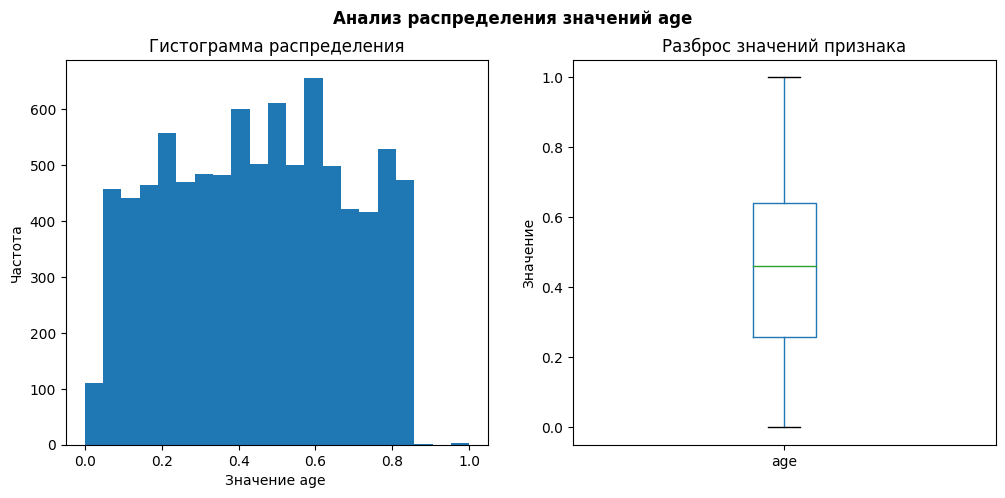


Описательная статистика age:
count   8_685.0000
mean        0.4500
std         0.2312
min         0.0000
25%         0.2584
50%         0.4607
75%         0.6404
max         1.0000
Name: age, dtype: float64


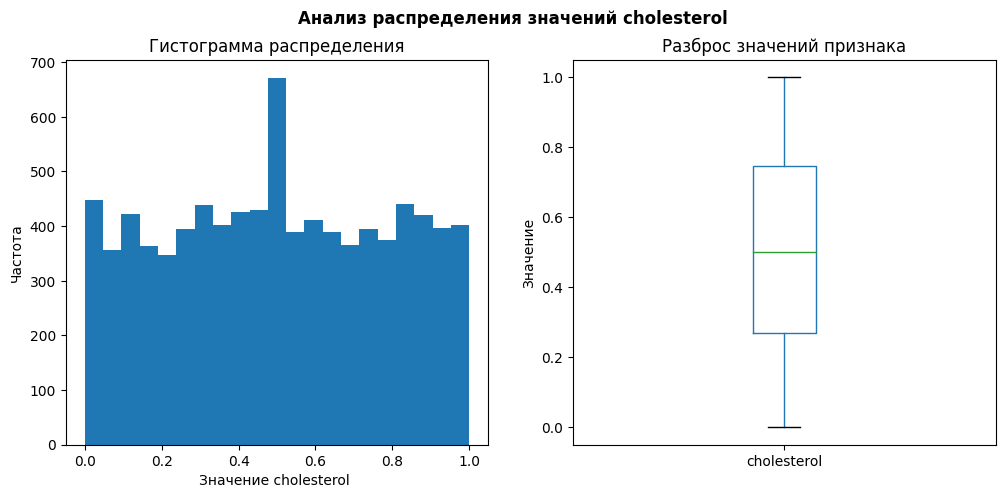


Описательная статистика cholesterol:
count   8_685.0000
mean        0.5011
std         0.2847
min         0.0000
25%         0.2679
50%         0.4998
75%         0.7464
max         1.0000
Name: cholesterol, dtype: float64


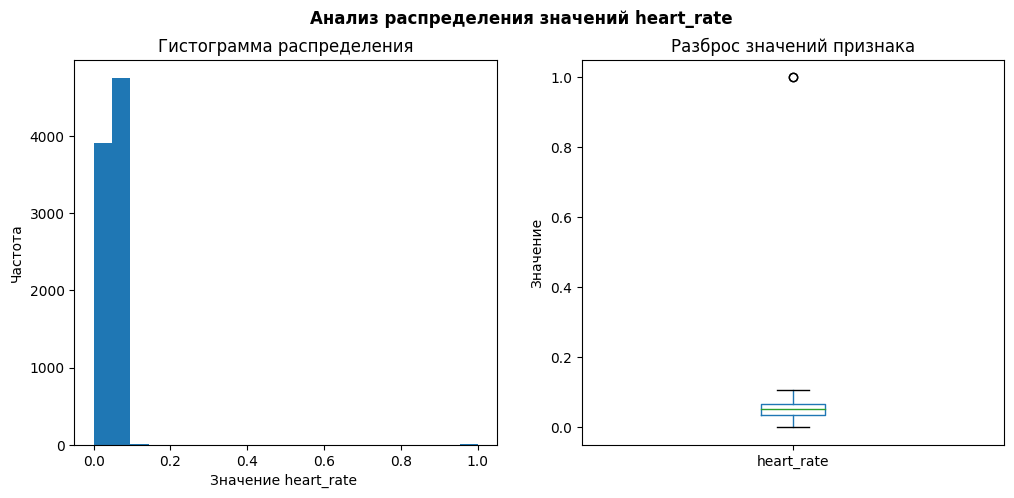


Описательная статистика heart_rate:
count   8_685.0000
mean        0.0507
std         0.0235
min         0.0000
25%         0.0348
50%         0.0504
75%         0.0660
max         1.0000
Name: heart_rate, dtype: float64


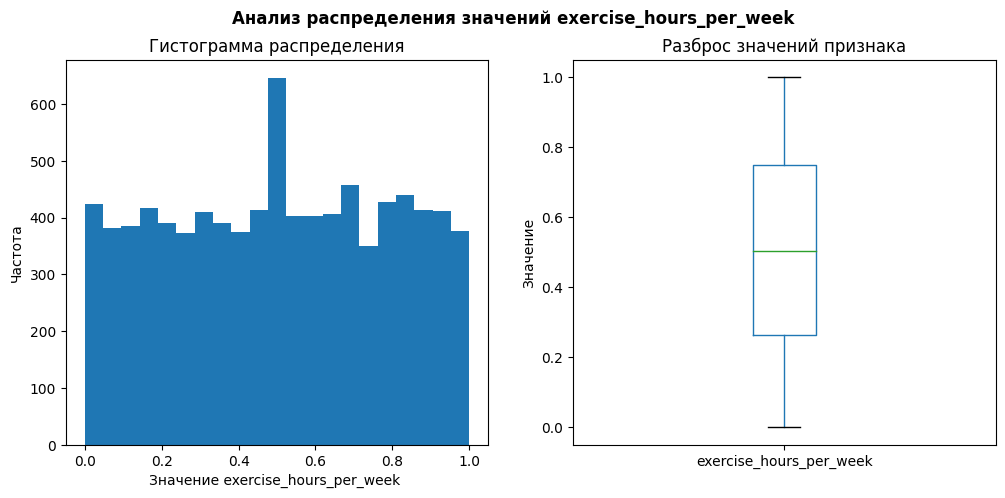


Описательная статистика exercise_hours_per_week:
count   8_685.0000
mean        0.5034
std         0.2848
min         0.0000
25%         0.2633
50%         0.5021
75%         0.7487
max         1.0000
Name: exercise_hours_per_week, dtype: float64


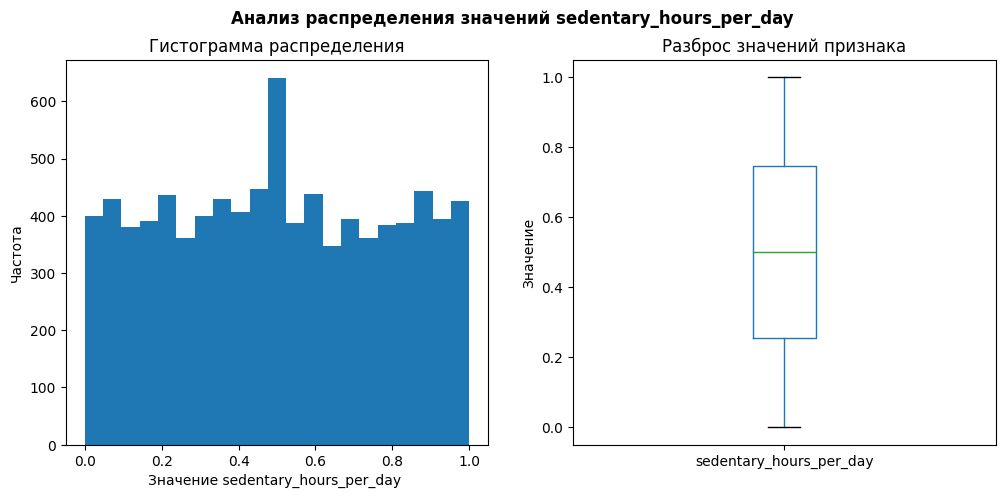


Описательная статистика sedentary_hours_per_day:
count   8_685.0000
mean        0.4992
std         0.2853
min         0.0000
25%         0.2559
50%         0.4999
75%         0.7446
max         1.0000
Name: sedentary_hours_per_day, dtype: float64


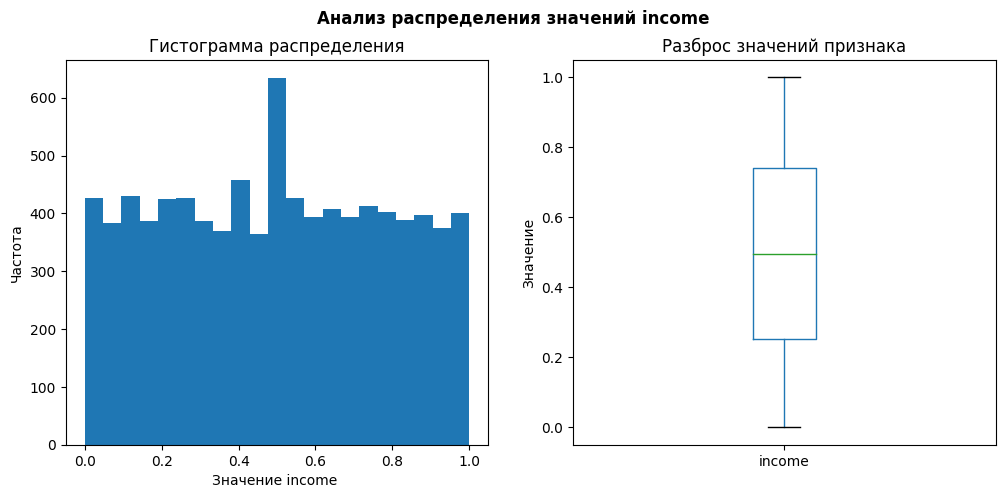


Описательная статистика income:
count   8_685.0000
mean        0.4961
std         0.2847
min         0.0000
25%         0.2519
50%         0.4949
75%         0.7410
max         1.0000
Name: income, dtype: float64


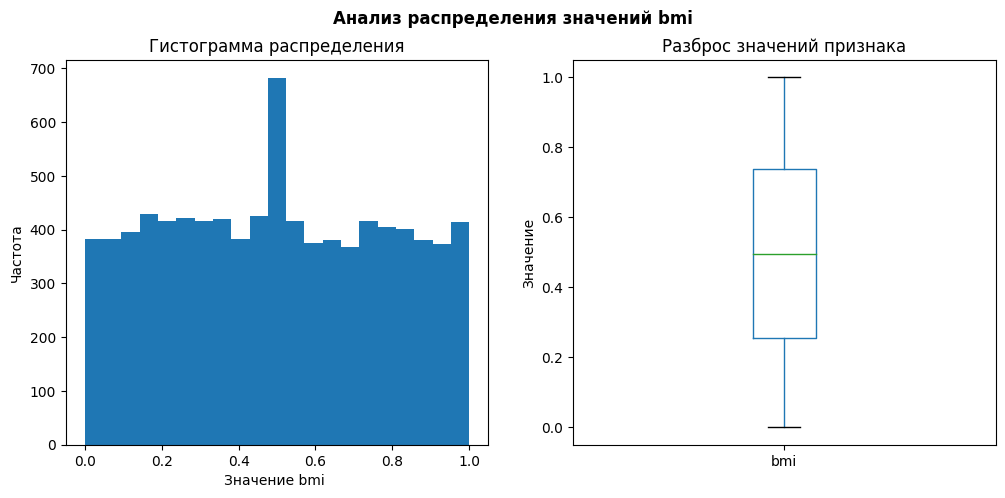


Описательная статистика bmi:
count   8_685.0000
mean        0.4968
std         0.2826
min         0.0000
25%         0.2542
50%         0.4948
75%         0.7370
max         1.0000
Name: bmi, dtype: float64


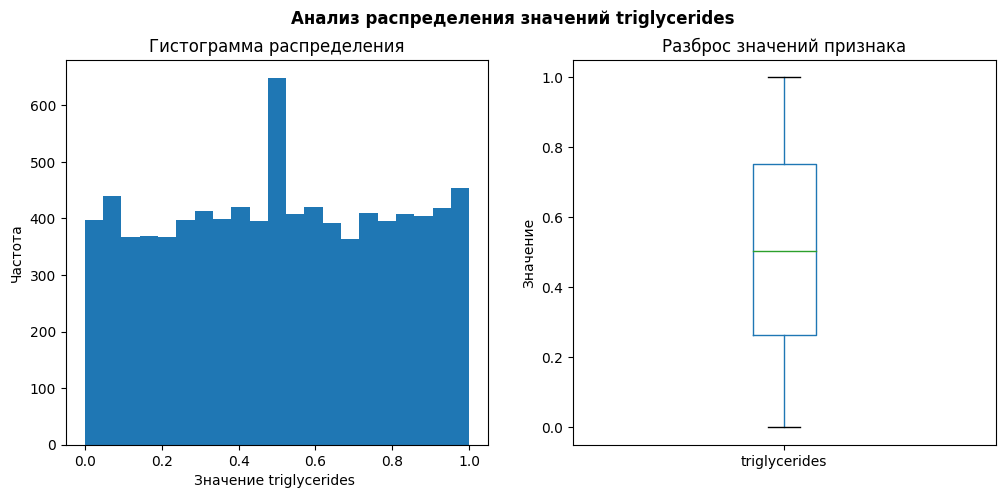


Описательная статистика triglycerides:
count   8_685.0000
mean        0.5055
std         0.2863
min         0.0000
25%         0.2636
50%         0.5036
75%         0.7506
max         1.0000
Name: triglycerides, dtype: float64


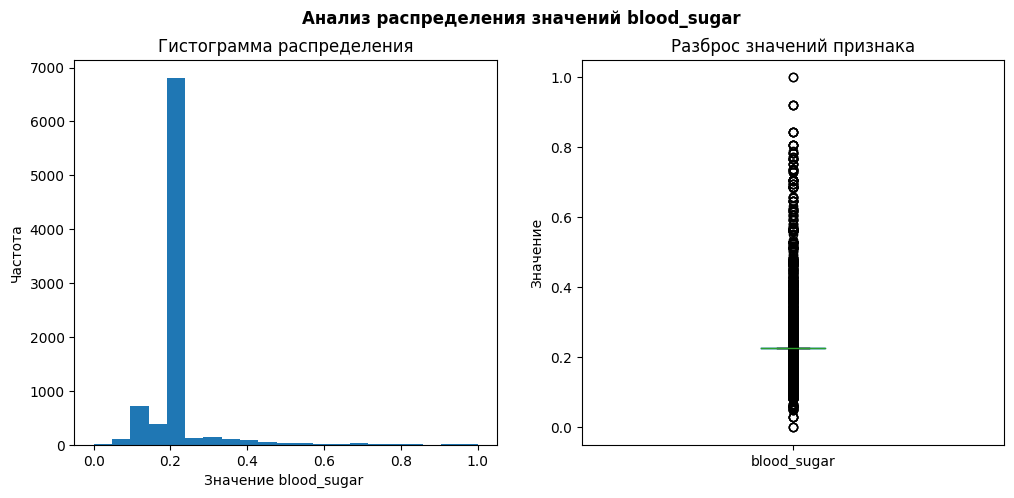


Описательная статистика blood_sugar:
count   8_685.0000
mean        0.2273
std         0.0766
min         0.0000
25%         0.2270
50%         0.2270
75%         0.2270
max         1.0000
Name: blood_sugar, dtype: float64


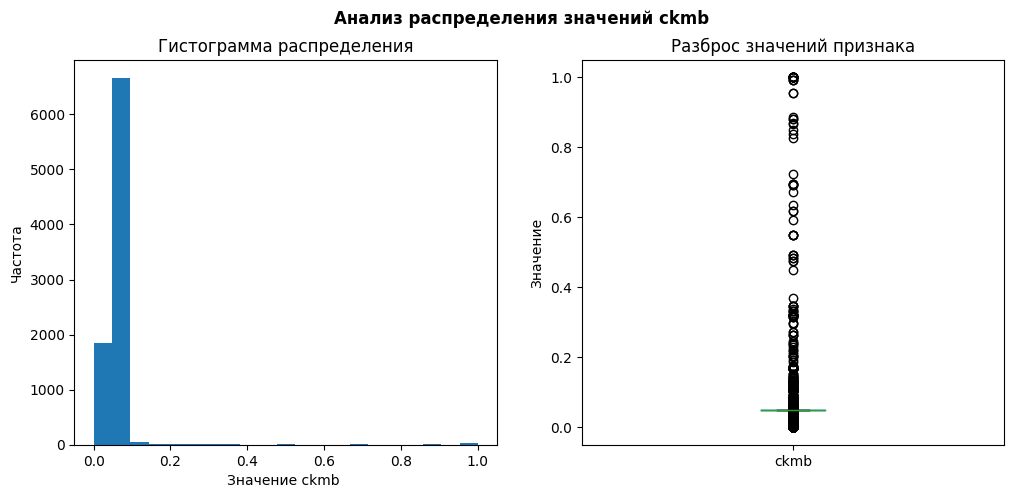


Описательная статистика ckmb:
count   8_685.0000
mean        0.0482
std         0.0755
min         0.0000
25%         0.0482
50%         0.0482
75%         0.0482
max         1.0000
Name: ckmb, dtype: float64


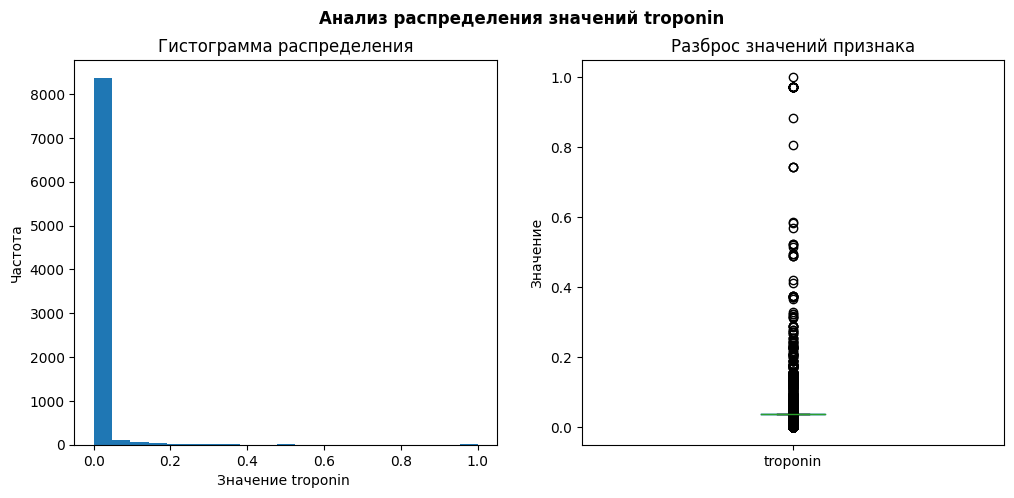


Описательная статистика troponin:
count   8_685.0000
mean        0.0367
std         0.0602
min         0.0000
25%         0.0365
50%         0.0365
75%         0.0365
max         1.0000
Name: troponin, dtype: float64


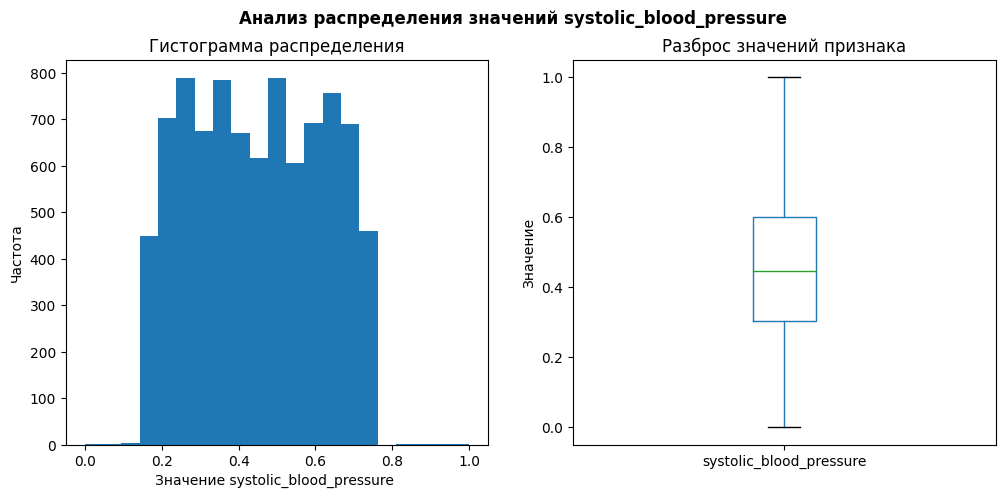


Описательная статистика systolic_blood_pressure:
count   8_685.0000
mean        0.4503
std         0.1702
min         0.0000
25%         0.3032
50%         0.4452
75%         0.6000
max         1.0000
Name: systolic_blood_pressure, dtype: float64


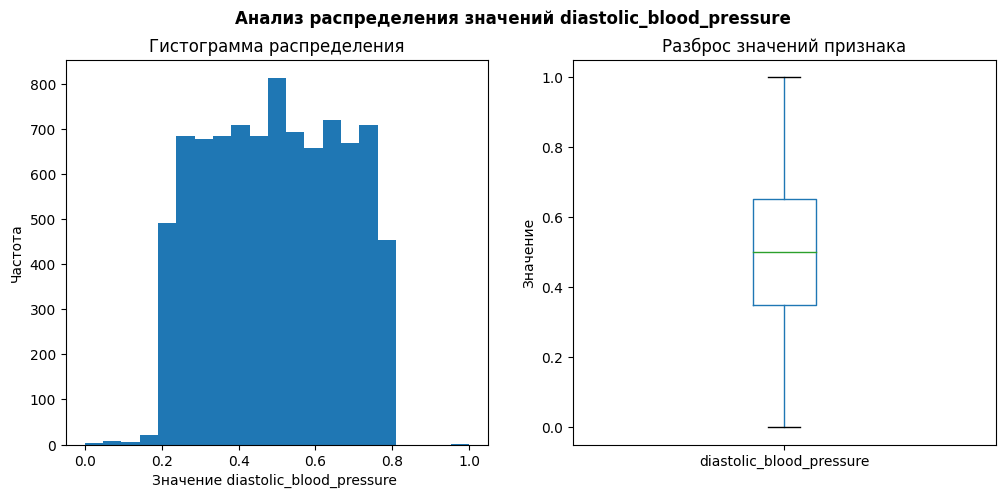


Описательная статистика diastolic_blood_pressure:
count   8_685.0000
mean        0.4976
std         0.1718
min         0.0000
25%         0.3488
50%         0.5000
75%         0.6512
max         1.0000
Name: diastolic_blood_pressure, dtype: float64


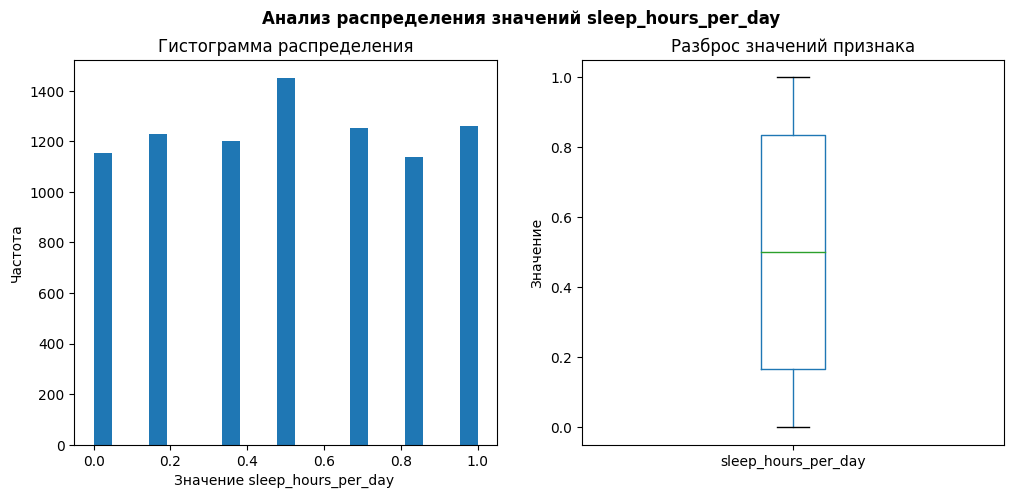


Описательная статистика sleep_hours_per_day:
count   8_685.0000
mean        0.5037
std         0.3281
min         0.0000
25%         0.1667
50%         0.5000
75%         0.8333
max         1.0000
Name: sleep_hours_per_day, dtype: float64


In [34]:
for column in num_columns:
    plot_hist_box(df_full[column], bins=21)

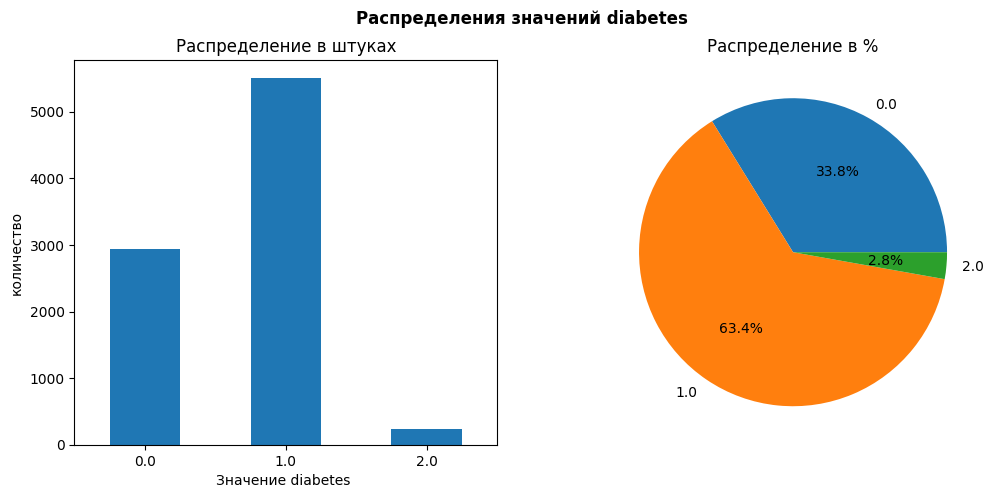


Описательная статистика diabetes:
count   8_685.0000
mean        0.6898
std         0.5196
min         0.0000
25%         0.0000
50%         1.0000
75%         1.0000
max         2.0000
Name: diabetes, dtype: float64


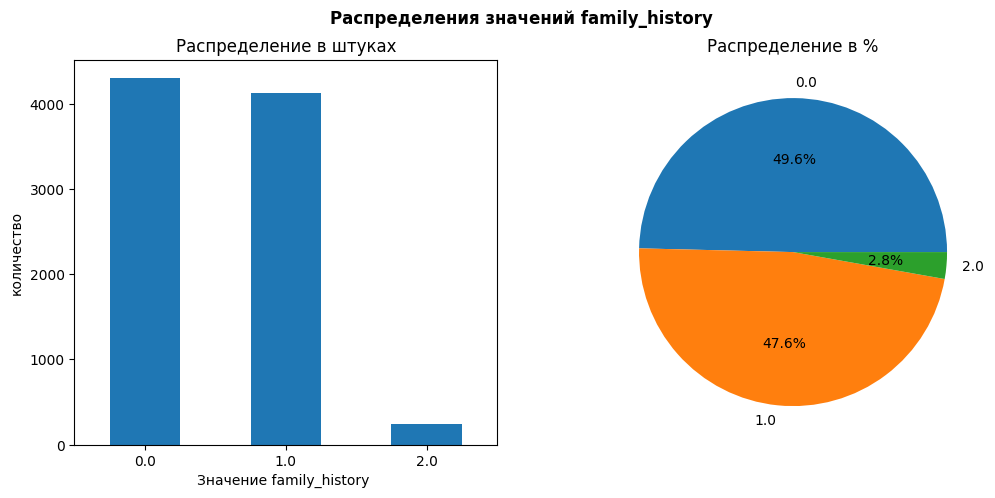


Описательная статистика family_history:
count   8_685.0000
mean        0.5318
std         0.5523
min         0.0000
25%         0.0000
50%         1.0000
75%         1.0000
max         2.0000
Name: family_history, dtype: float64


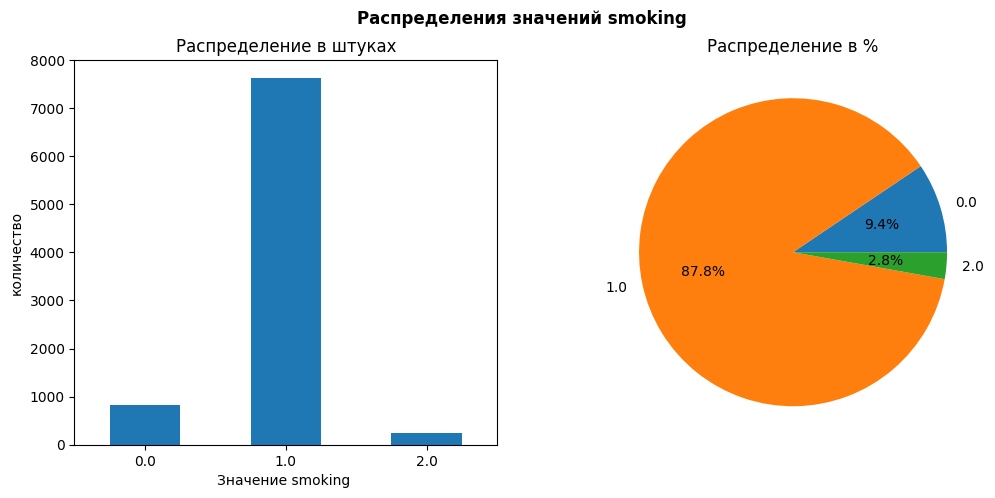


Описательная статистика smoking:
count   8_685.0000
mean        0.9336
std         0.3435
min         0.0000
25%         1.0000
50%         1.0000
75%         1.0000
max         2.0000
Name: smoking, dtype: float64


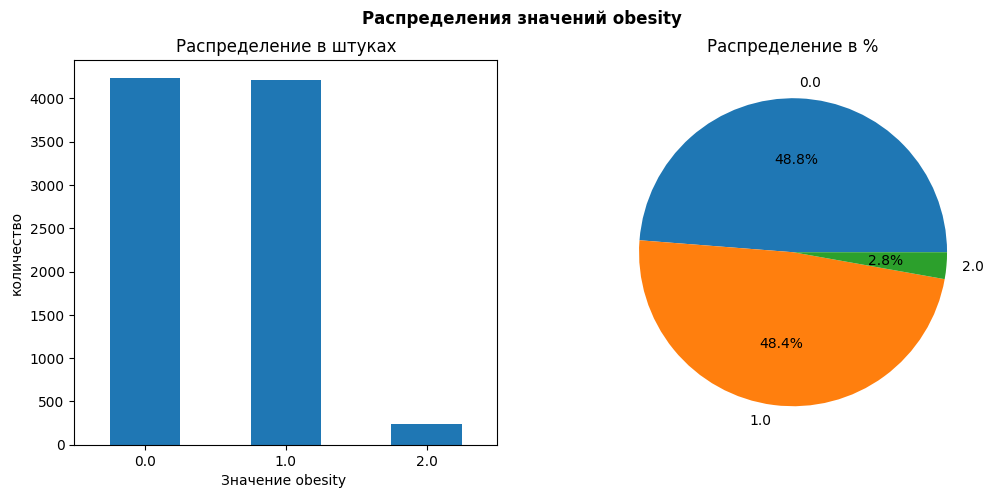


Описательная статистика obesity:
count   8_685.0000
mean        0.5404
std         0.5517
min         0.0000
25%         0.0000
50%         1.0000
75%         1.0000
max         2.0000
Name: obesity, dtype: float64


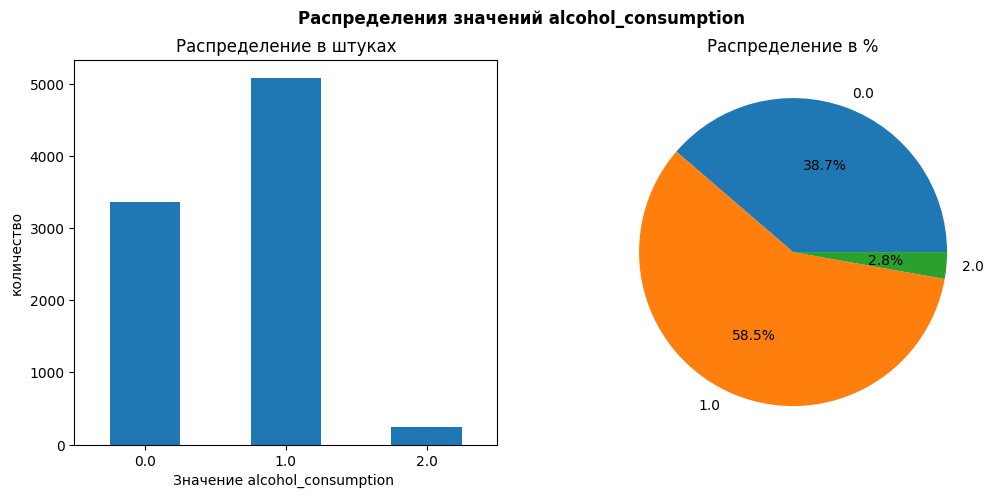


Описательная статистика alcohol_consumption:
count   8_685.0000
mean        0.6411
std         0.5349
min         0.0000
25%         0.0000
50%         1.0000
75%         1.0000
max         2.0000
Name: alcohol_consumption, dtype: float64


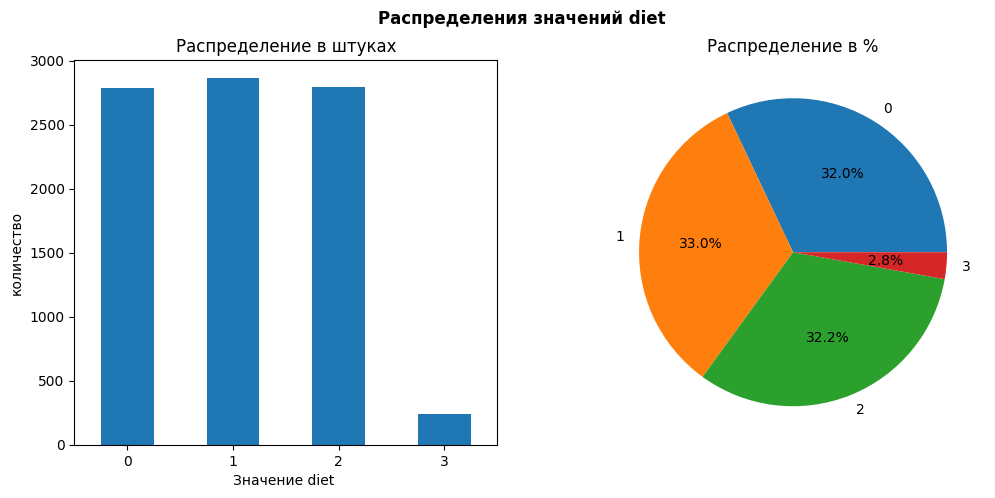


Описательная статистика diet:
count   8_685.0000
mean        1.0575
std         0.8666
min         0.0000
25%         0.0000
50%         1.0000
75%         2.0000
max         3.0000
Name: diet, dtype: float64


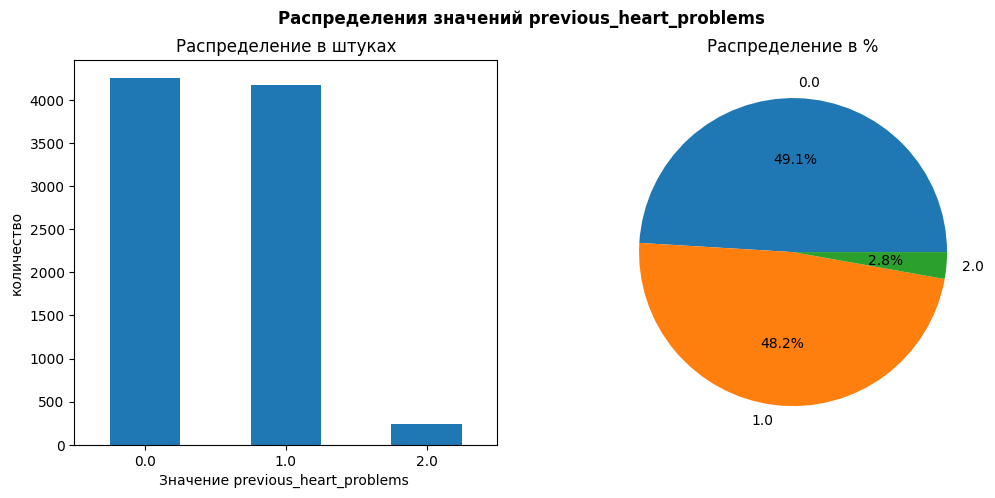


Описательная статистика previous_heart_problems:
count   8_685.0000
mean        0.5375
std         0.5519
min         0.0000
25%         0.0000
50%         1.0000
75%         1.0000
max         2.0000
Name: previous_heart_problems, dtype: float64


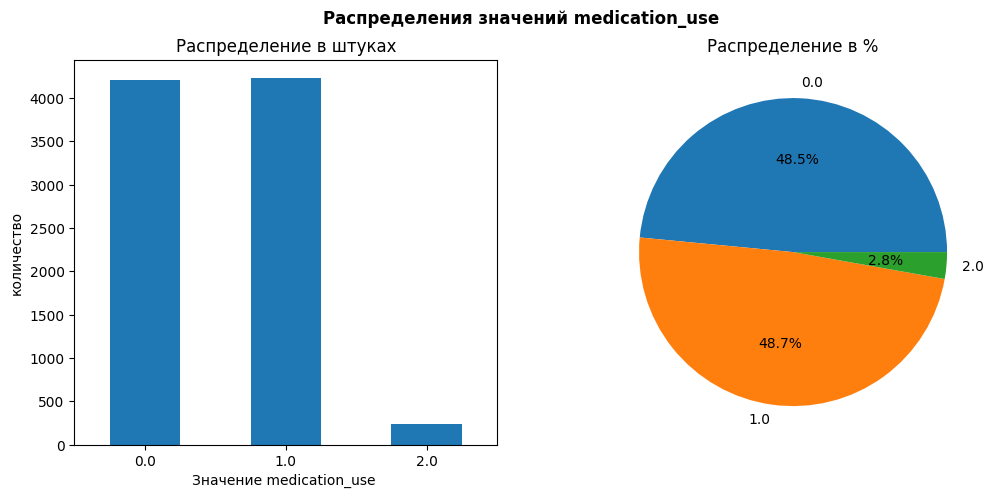


Описательная статистика medication_use:
count   8_685.0000
mean        0.5431
std         0.5515
min         0.0000
25%         0.0000
50%         1.0000
75%         1.0000
max         2.0000
Name: medication_use, dtype: float64


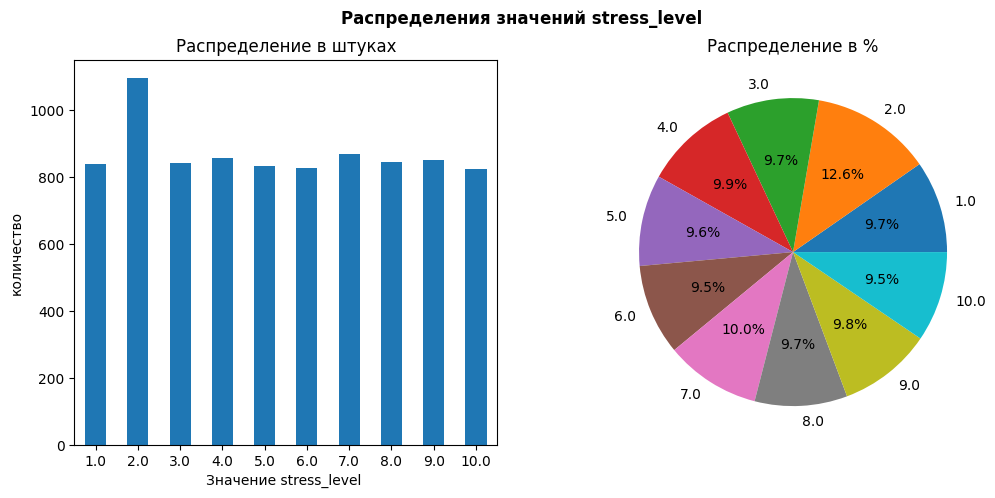


Описательная статистика stress_level:
count   8_685.0000
mean        5.3956
std         2.8856
min         1.0000
25%         3.0000
50%         5.0000
75%         8.0000
max        10.0000
Name: stress_level, dtype: float64


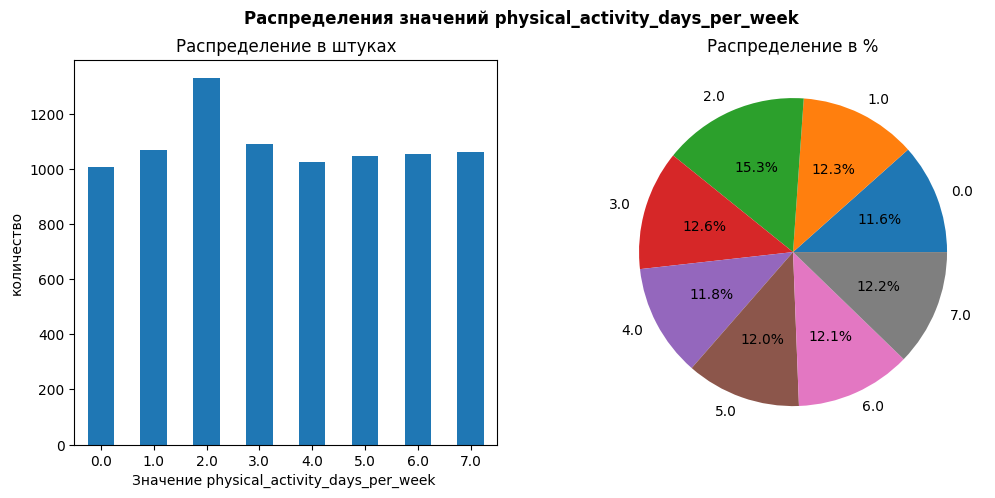


Описательная статистика physical_activity_days_per_week:
count   8_685.0000
mean        3.4661
std         2.2633
min         0.0000
25%         2.0000
50%         3.0000
75%         5.0000
max         7.0000
Name: physical_activity_days_per_week, dtype: float64


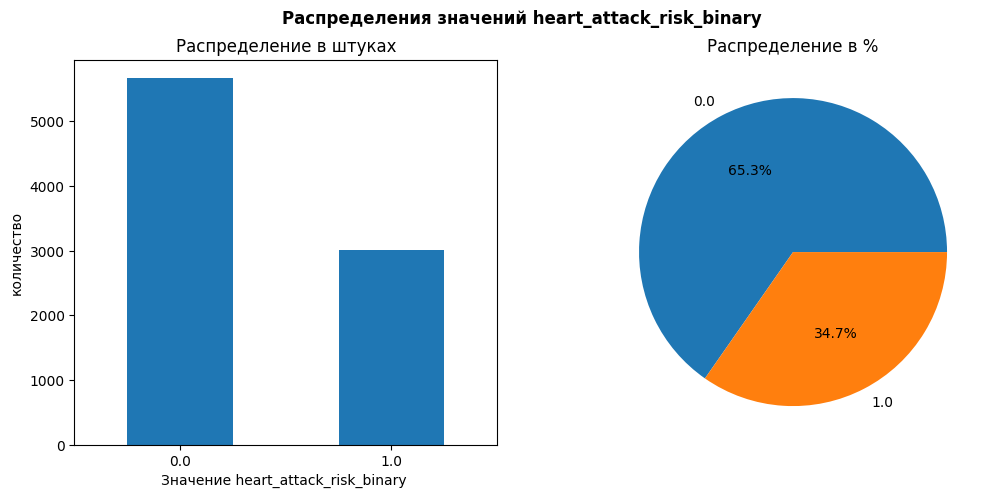


Описательная статистика heart_attack_risk_binary:
count   8_685.0000
mean        0.3469
std         0.4760
min         0.0000
25%         0.0000
50%         0.0000
75%         1.0000
max         1.0000
Name: heart_attack_risk_binary, dtype: float64


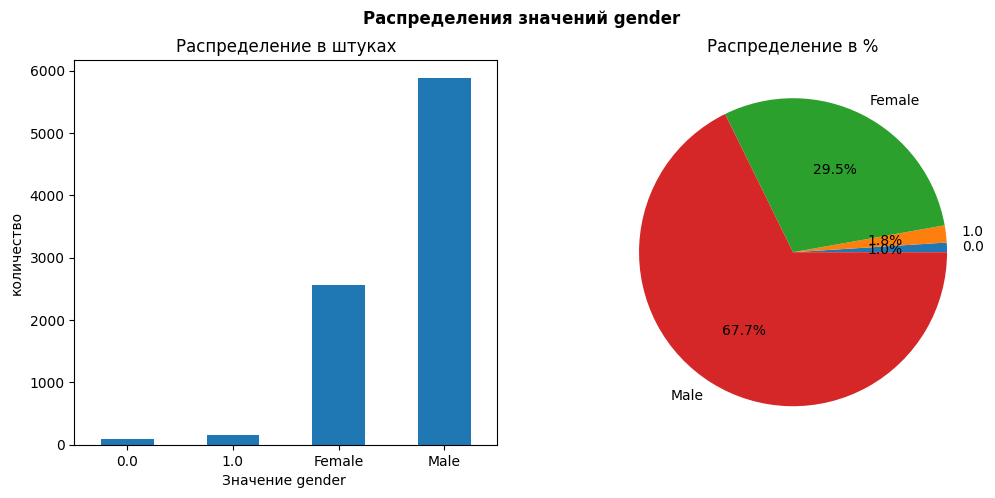


Описательная статистика gender:
count     8685
unique       4
top       Male
freq      5882
Name: gender, dtype: object


In [35]:
for column in cat_columns:
    plot_bar_pie(df_full[column])

    - 'age' - данные масштабированы
    - 'heart_rate' - выброс
    - 'diabetes' - категориальный закодированный
    - 'family_history' - категориальный закодированный
    - 'smoking' - категориальный закодированный
    - 'obesity' - категориальный закодированный
    - 'alcohol_consumption' - категориальный закодированный
    - 'previous_heart_problems' - категориальный закодированный
    - 'medication_use' - категориальный закодированный
    - 'stress_level' - категориальный закодированный
    - 'physical_activity_days_per_week' - категориальный закодированный
    - 'heart_attack_risk_binary' - категориальный закодированный целувой признак
    - 'gender' категориальный часть данных закодирована

In [36]:
df_full.query('heart_rate > 0.2')

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_binary,blood_sugar,ckmb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure
id,,,,,,,,,,,,,,,,,,,,,,,,,,
9547,0.6292,0.4998,1.0000,2.0000,2.0000,2.0000,2.0000,2.0000,0.5021,3,2.0000,2.0000,2.0000,0.4999,0.4949,0.4948,0.5036,2.0000,0.5046,0.0000,0.2036,0.0118,0.0026,0.0,0.4903,0.6163
9611,0.2022,0.4998,1.0000,2.0000,2.0000,2.0000,2.0000,2.0000,0.5021,3,2.0000,2.0000,2.0000,0.4999,0.4949,0.4948,0.5036,2.0000,0.5046,0.0000,0.0929,0.0078,0.0007,0.0,0.4903,0.6163


Скорее всего при масштабировании данных не был обработан выброс. Можем его удалить, но более предпочтительным выгдядет использовать модель не чувствительную к вбросам. Для целей определения корркляций избавимся от выбросов

In [37]:
df_clean = df_clean.query('heart_rate < 0.2')

In [38]:
df_clean = df_clean.dropna()

Проиведем строковые занчени gender к 1 и 0

In [39]:
df_clean['gender'] = df_clean['gender'].replace({'Male': 1, 'Female': 0})
df_clean['gender'] = pd.to_numeric(df_clean['gender'])

In [40]:
df_full['gender'] = df_full['gender'].replace({'Male': 1, 'Female': 0})
df_full['gender'] = pd.to_numeric(df_full['gender'])

In [41]:
#df_clean['gender'].loc[df_clean['gender'] == 'Male'] = 1
#df_clean['gender'].loc[df_clean['gender'] == 'Female'] = 0

In [42]:
df_clean = df_clean.astype({
    'diabetes': 'int',
    'family_history': 'int',
    'smoking': 'int',
    'obesity': 'int',
    'alcohol_consumption': 'int',
    'previous_heart_problems': 'int',
    'medication_use': 'int',
    'stress_level': 'int',
    'physical_activity_days_per_week': 'int',
    'heart_attack_risk_binary': 'int',
    'gender': 'int'
})

In [43]:
df_clean['gender'] = pd.to_numeric(df_clean['gender'])

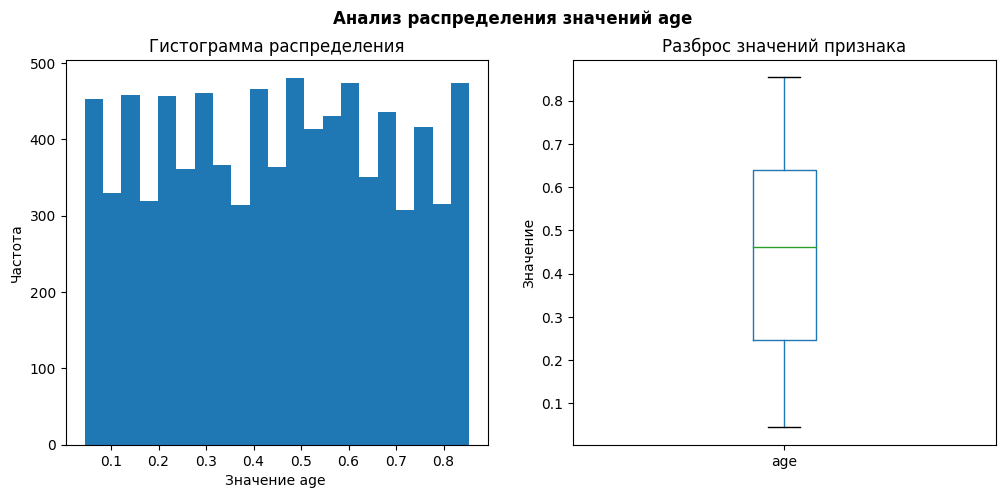


Описательная статистика age:
count   8_442.0000
mean        0.4490
std         0.2328
min         0.0449
25%         0.2472
50%         0.4607
75%         0.6404
max         0.8539
Name: age, dtype: float64


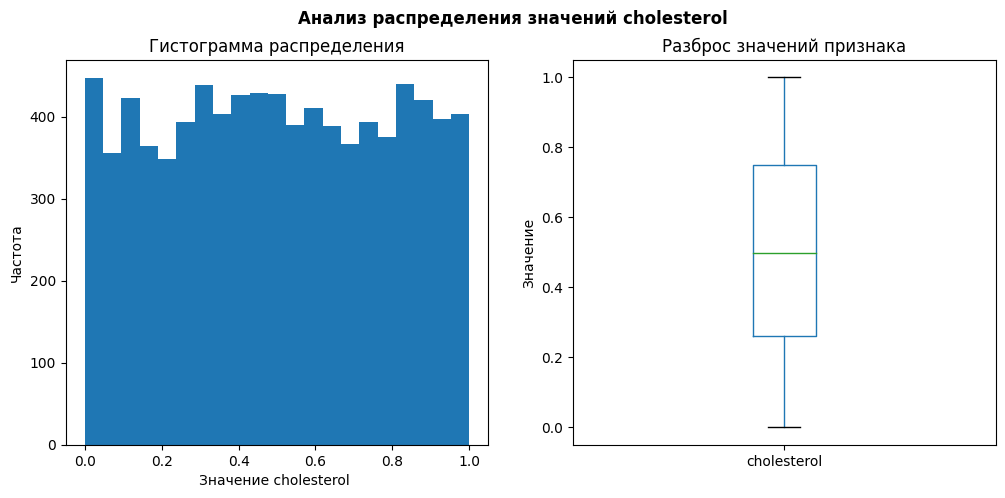


Описательная статистика cholesterol:
count   8_442.0000
mean        0.5011
std         0.2888
min         0.0000
25%         0.2607
50%         0.4964
75%         0.7500
max         1.0000
Name: cholesterol, dtype: float64


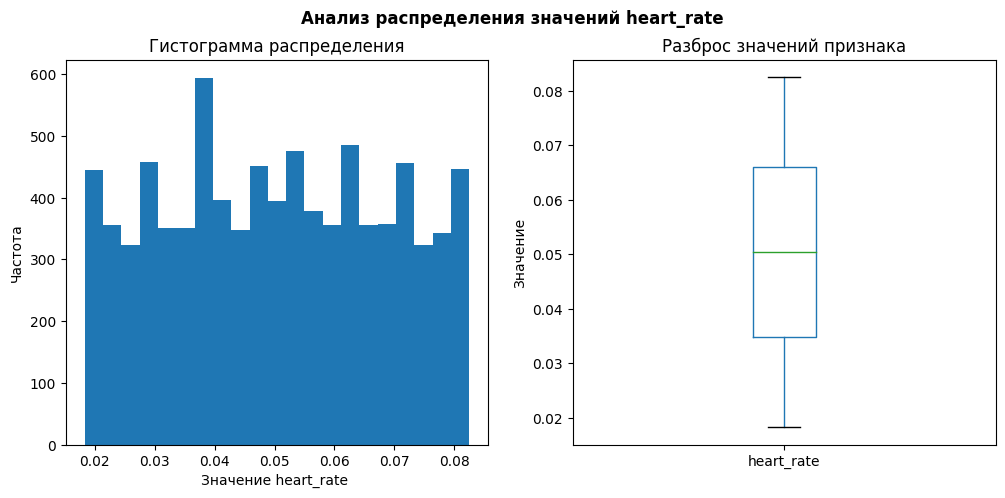


Описательная статистика heart_rate:
count   8_442.0000
mean        0.0502
std         0.0184
min         0.0183
25%         0.0348
50%         0.0504
75%         0.0660
max         0.0825
Name: heart_rate, dtype: float64


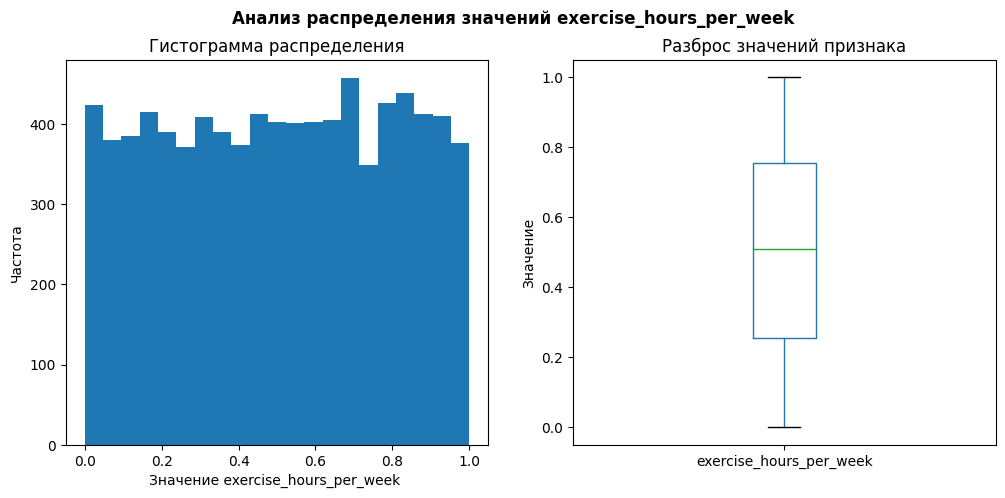


Описательная статистика exercise_hours_per_week:
count   8_442.0000
mean        0.5034
std         0.2889
min         0.0000
25%         0.2534
50%         0.5082
75%         0.7549
max         1.0000
Name: exercise_hours_per_week, dtype: float64


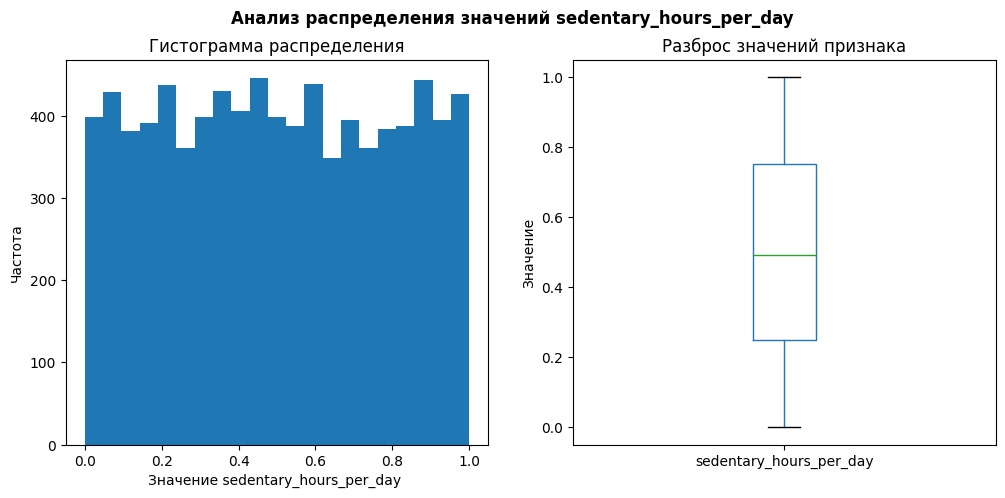


Описательная статистика sedentary_hours_per_day:
count   8_442.0000
mean        0.4991
std         0.2894
min         0.0000
25%         0.2477
50%         0.4927
75%         0.7510
max         1.0000
Name: sedentary_hours_per_day, dtype: float64


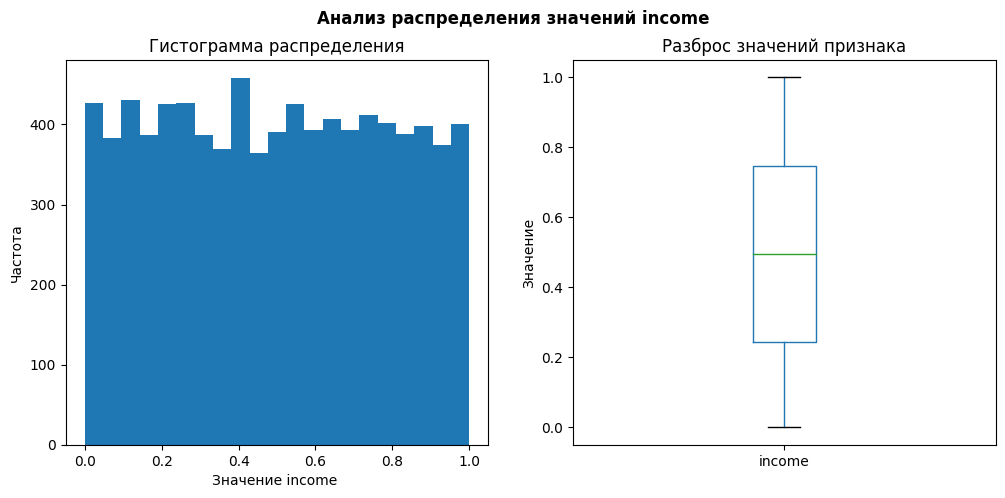


Описательная статистика income:
count   8_442.0000
mean        0.4961
std         0.2888
min         0.0000
25%         0.2446
50%         0.4961
75%         0.7476
max         1.0000
Name: income, dtype: float64


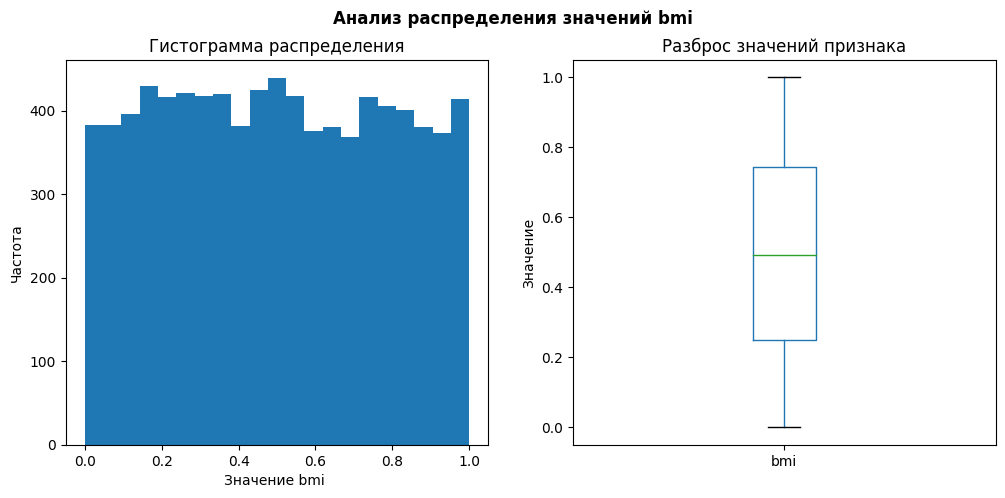


Описательная статистика bmi:
count   8_442.0000
mean        0.4968
std         0.2866
min         0.0000
25%         0.2479
50%         0.4908
75%         0.7444
max         1.0000
Name: bmi, dtype: float64


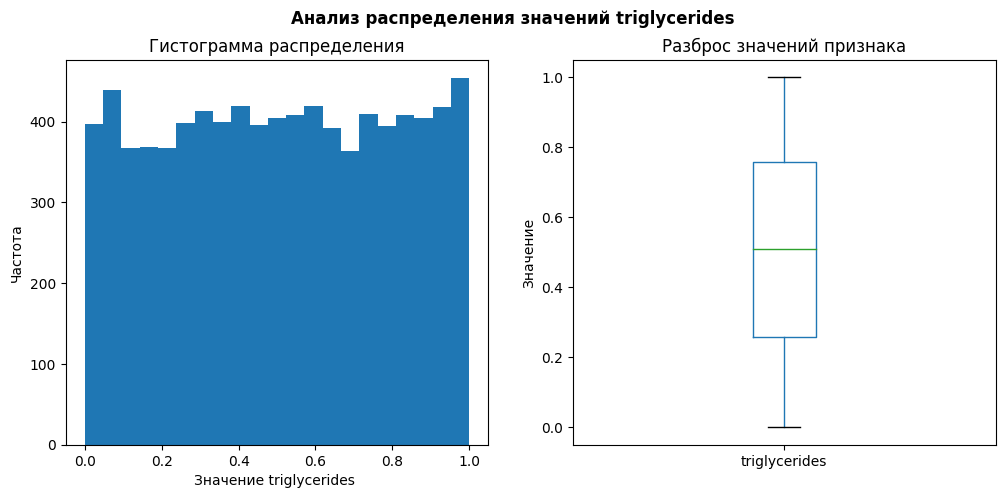


Описательная статистика triglycerides:
count   8_442.0000
mean        0.5055
std         0.2904
min         0.0000
25%         0.2571
50%         0.5078
75%         0.7584
max         1.0000
Name: triglycerides, dtype: float64


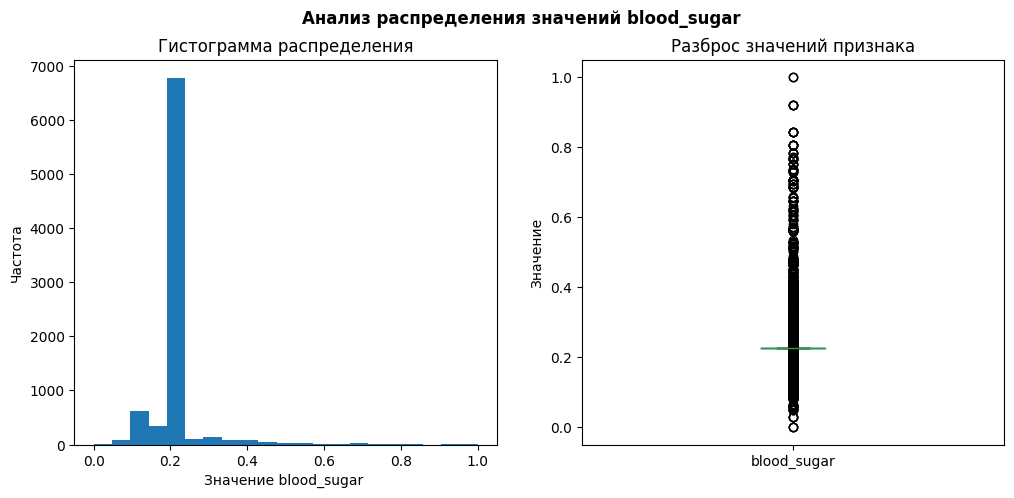


Описательная статистика blood_sugar:
count   8_442.0000
mean        0.2280
std         0.0746
min         0.0000
25%         0.2270
50%         0.2270
75%         0.2270
max         1.0000
Name: blood_sugar, dtype: float64


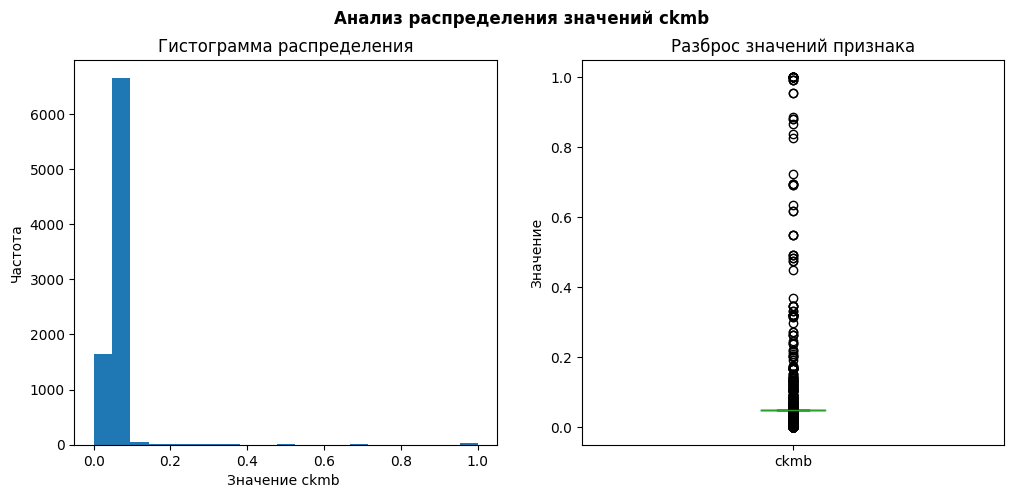


Описательная статистика ckmb:
count   8_442.0000
mean        0.0477
std         0.0704
min         0.0000
25%         0.0482
50%         0.0482
75%         0.0482
max         1.0000
Name: ckmb, dtype: float64


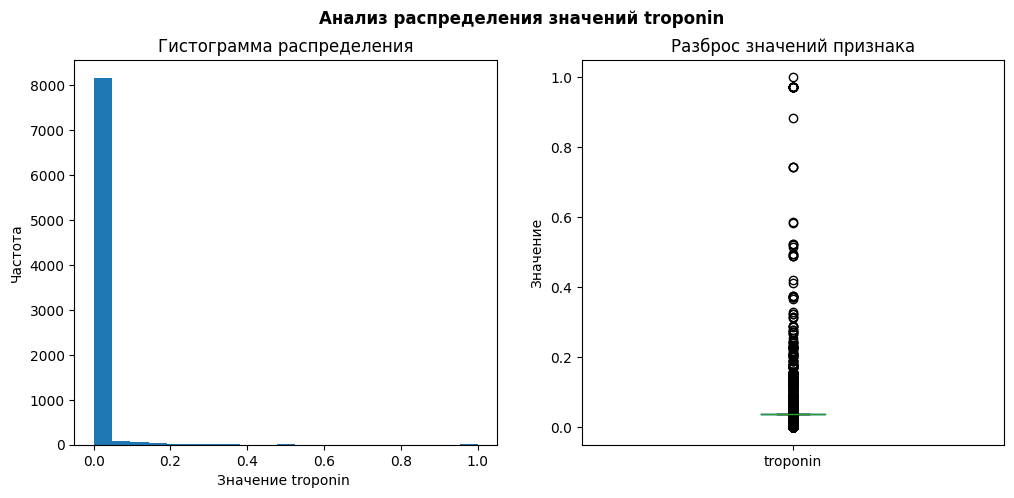


Описательная статистика troponin:
count   8_442.0000
mean        0.0369
std         0.0593
min         0.0000
25%         0.0365
50%         0.0365
75%         0.0365
max         1.0000
Name: troponin, dtype: float64


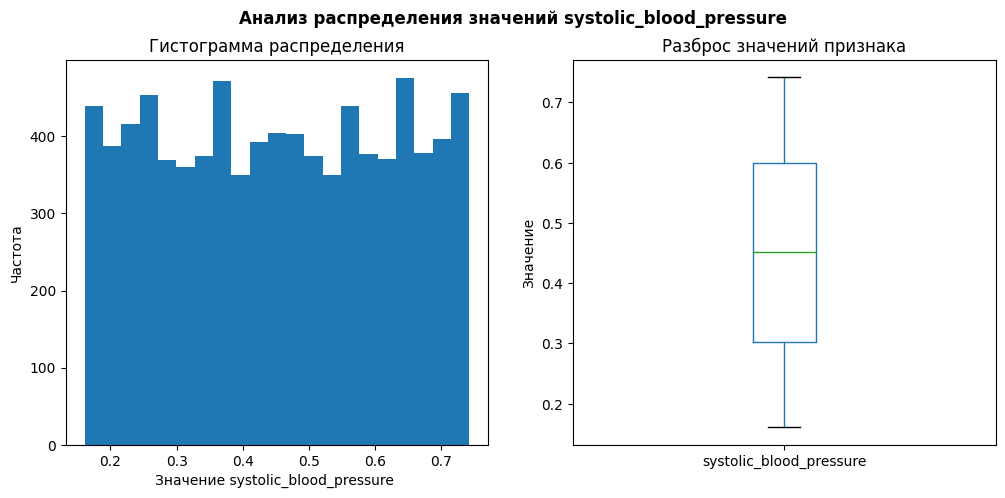


Описательная статистика systolic_blood_pressure:
count   8_442.0000
mean        0.4520
std         0.1702
min         0.1613
25%         0.3032
50%         0.4516
75%         0.6000
max         0.7419
Name: systolic_blood_pressure, dtype: float64


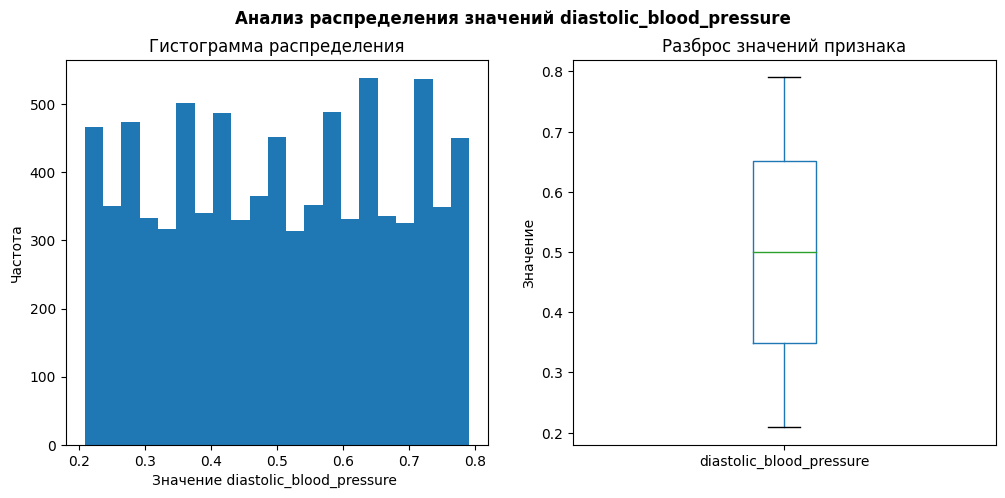


Описательная статистика diastolic_blood_pressure:
count   8_442.0000
mean        0.5017
std         0.1703
min         0.2093
25%         0.3488
50%         0.5000
75%         0.6512
max         0.7907
Name: diastolic_blood_pressure, dtype: float64


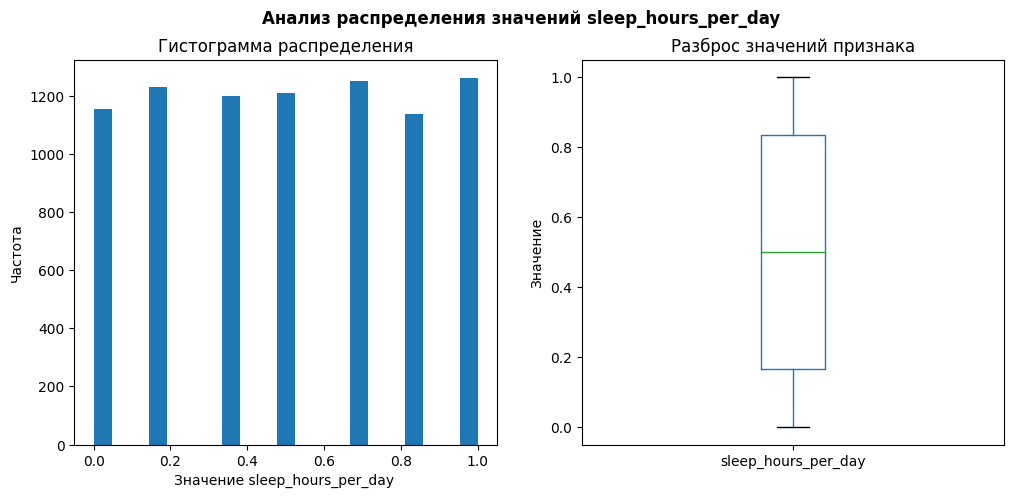


Описательная статистика sleep_hours_per_day:
count   8_442.0000
mean        0.5037
std         0.3327
min         0.0000
25%         0.1667
50%         0.5000
75%         0.8333
max         1.0000
Name: sleep_hours_per_day, dtype: float64


In [44]:
for column in num_columns:
    plot_hist_box(df_clean[column], bins=21)

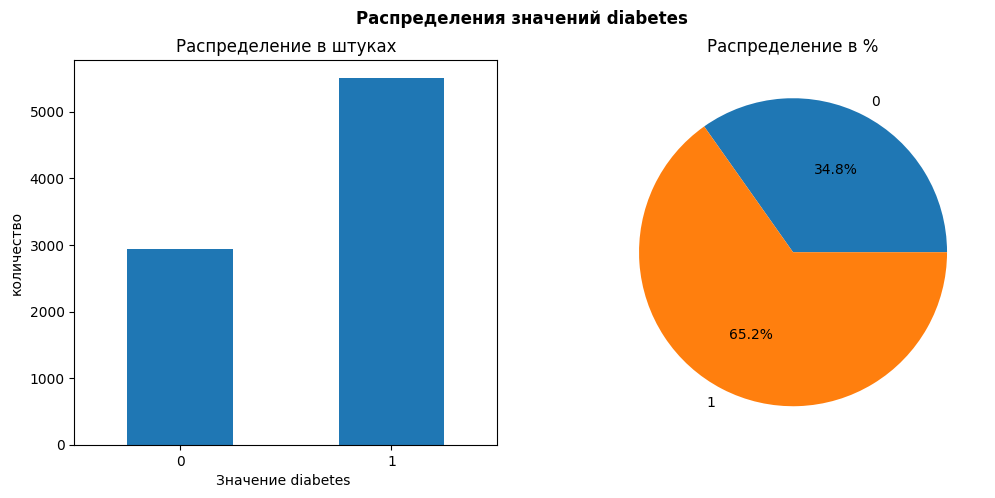


Описательная статистика diabetes:
count   8_442.0000
mean        0.6521
std         0.4763
min         0.0000
25%         0.0000
50%         1.0000
75%         1.0000
max         1.0000
Name: diabetes, dtype: float64


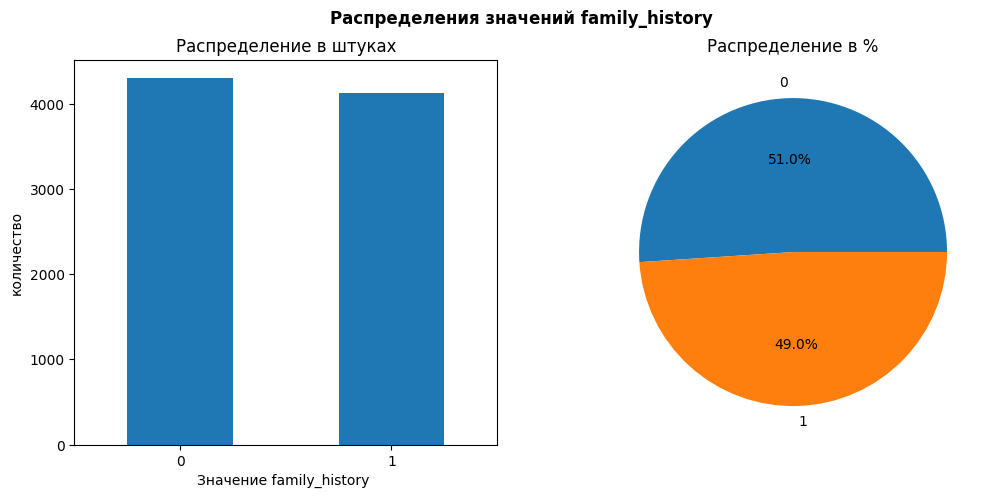


Описательная статистика family_history:
count   8_442.0000
mean        0.4896
std         0.4999
min         0.0000
25%         0.0000
50%         0.0000
75%         1.0000
max         1.0000
Name: family_history, dtype: float64


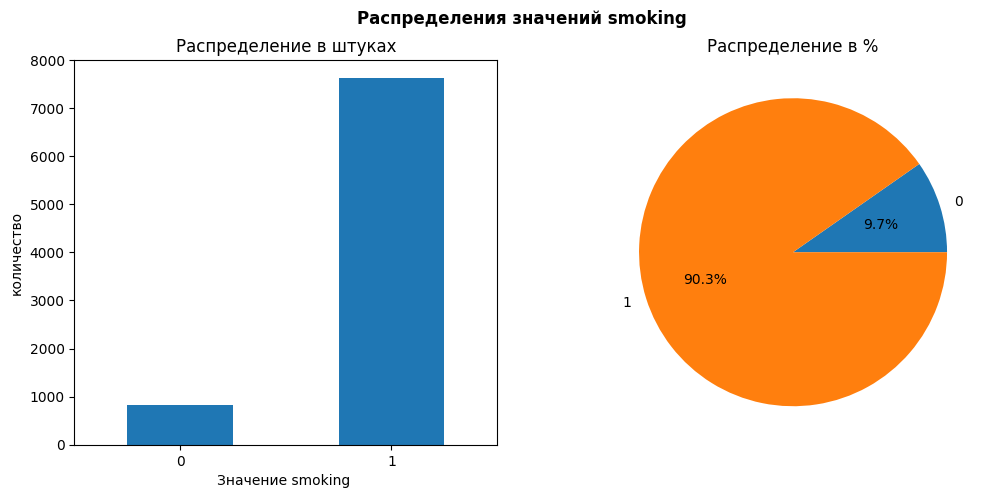


Описательная статистика smoking:
count   8_442.0000
mean        0.9029
std         0.2962
min         0.0000
25%         1.0000
50%         1.0000
75%         1.0000
max         1.0000
Name: smoking, dtype: float64


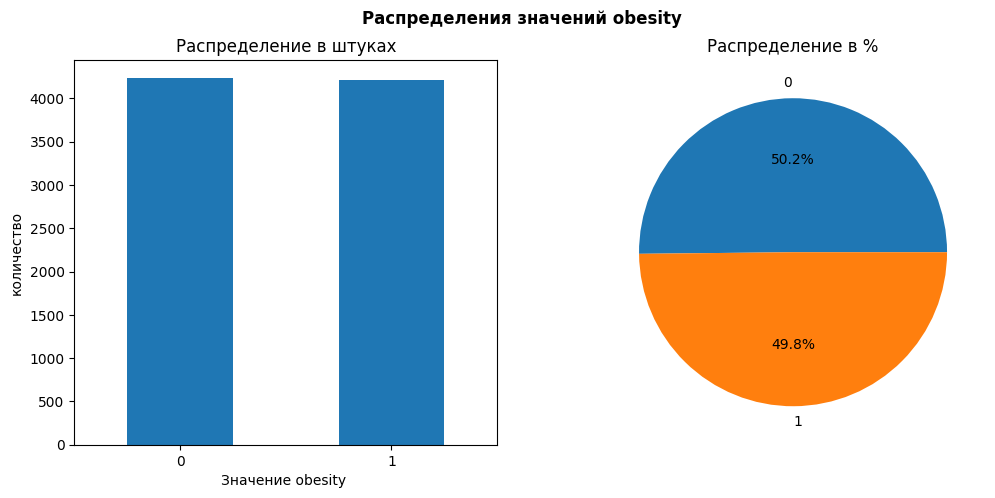


Описательная статистика obesity:
count   8_442.0000
mean        0.4983
std         0.5000
min         0.0000
25%         0.0000
50%         0.0000
75%         1.0000
max         1.0000
Name: obesity, dtype: float64


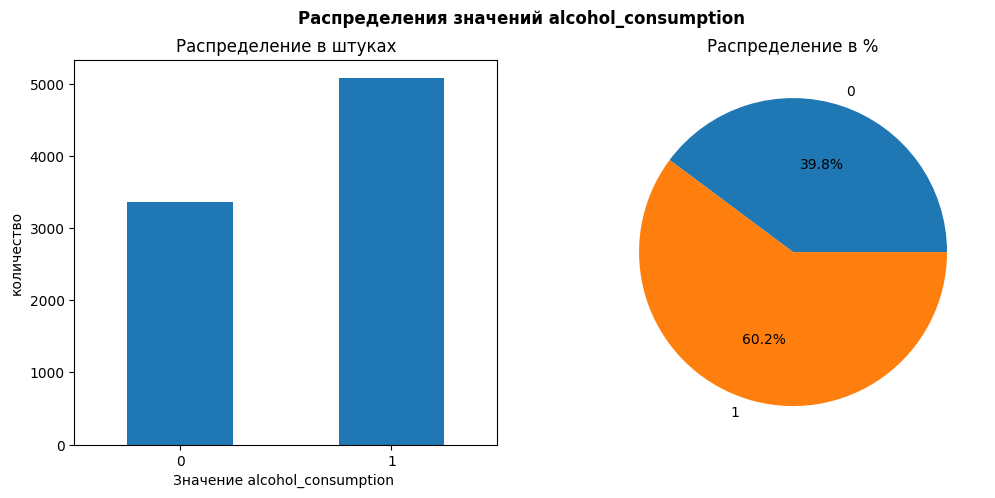


Описательная статистика alcohol_consumption:
count   8_442.0000
mean        0.6020
std         0.4895
min         0.0000
25%         0.0000
50%         1.0000
75%         1.0000
max         1.0000
Name: alcohol_consumption, dtype: float64


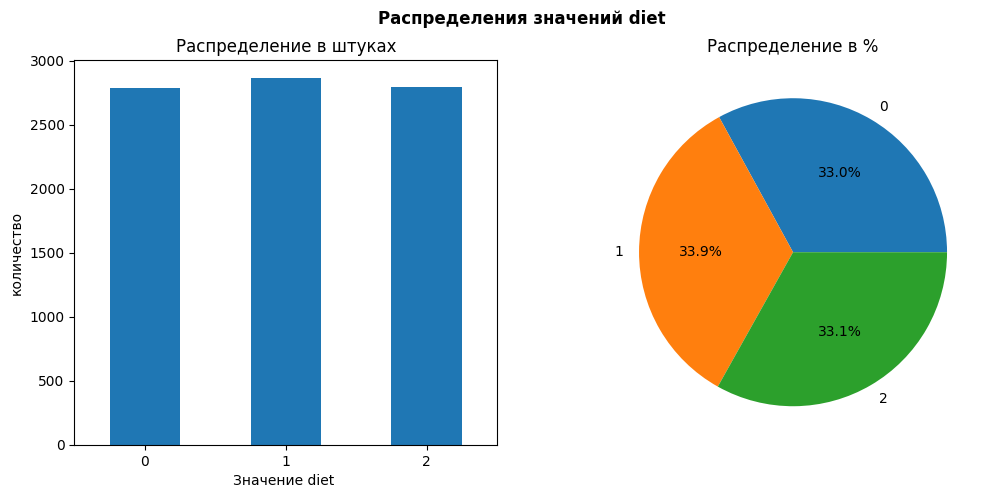


Описательная статистика diet:
count   8_442.0000
mean        1.0015
std         0.8130
min         0.0000
25%         0.0000
50%         1.0000
75%         2.0000
max         2.0000
Name: diet, dtype: float64


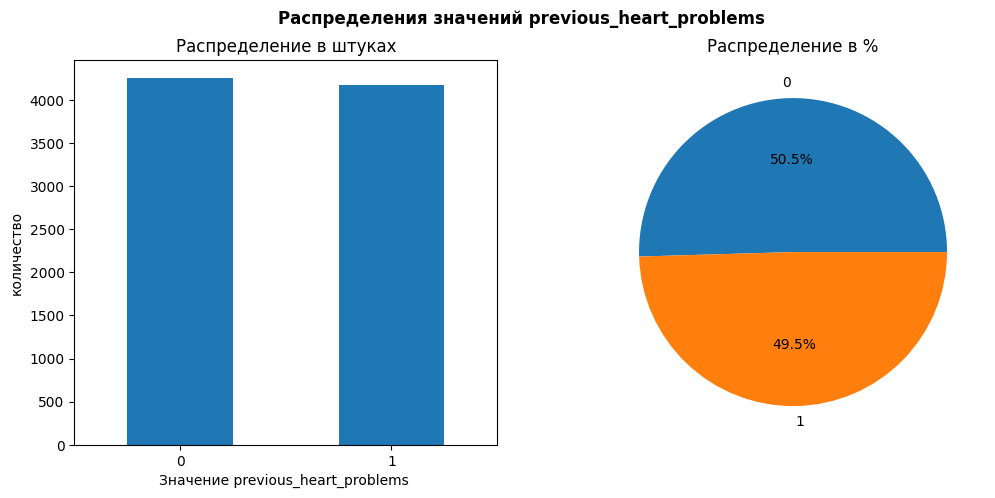


Описательная статистика previous_heart_problems:
count   8_442.0000
mean        0.4954
std         0.5000
min         0.0000
25%         0.0000
50%         0.0000
75%         1.0000
max         1.0000
Name: previous_heart_problems, dtype: float64


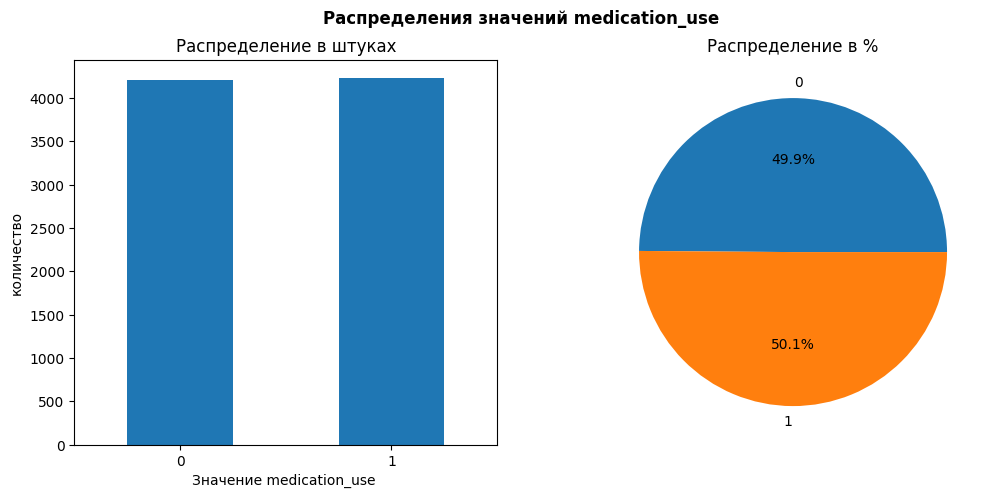


Описательная статистика medication_use:
count   8_442.0000
mean        0.5012
std         0.5000
min         0.0000
25%         0.0000
50%         1.0000
75%         1.0000
max         1.0000
Name: medication_use, dtype: float64


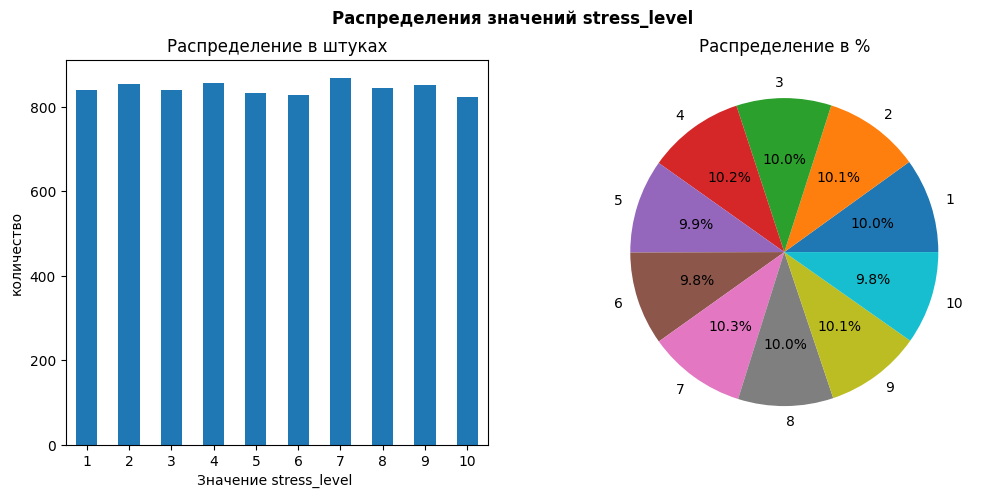


Описательная статистика stress_level:
count   8_442.0000
mean        5.4934
std         2.8679
min         1.0000
25%         3.0000
50%         5.0000
75%         8.0000
max        10.0000
Name: stress_level, dtype: float64


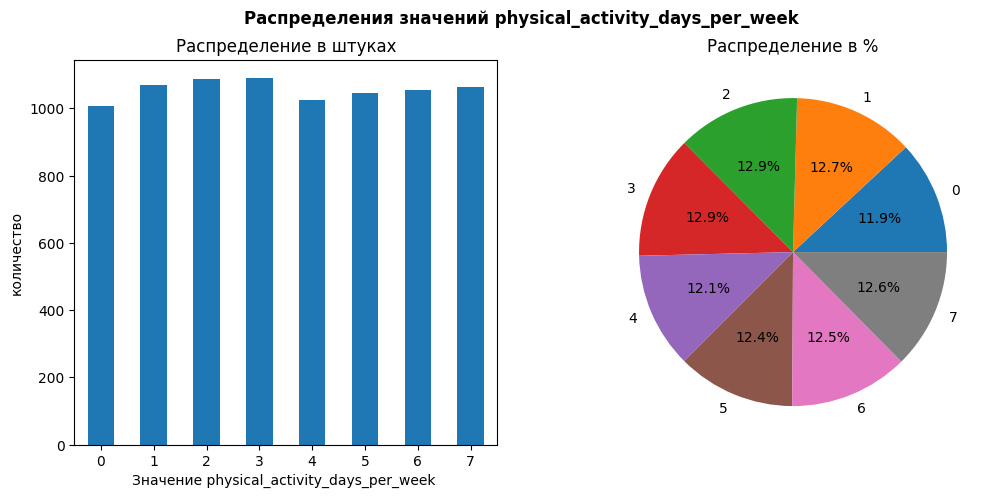


Описательная статистика physical_activity_days_per_week:
count   8_442.0000
mean        3.5083
std         2.2818
min         0.0000
25%         2.0000
50%         3.0000
75%         6.0000
max         7.0000
Name: physical_activity_days_per_week, dtype: float64


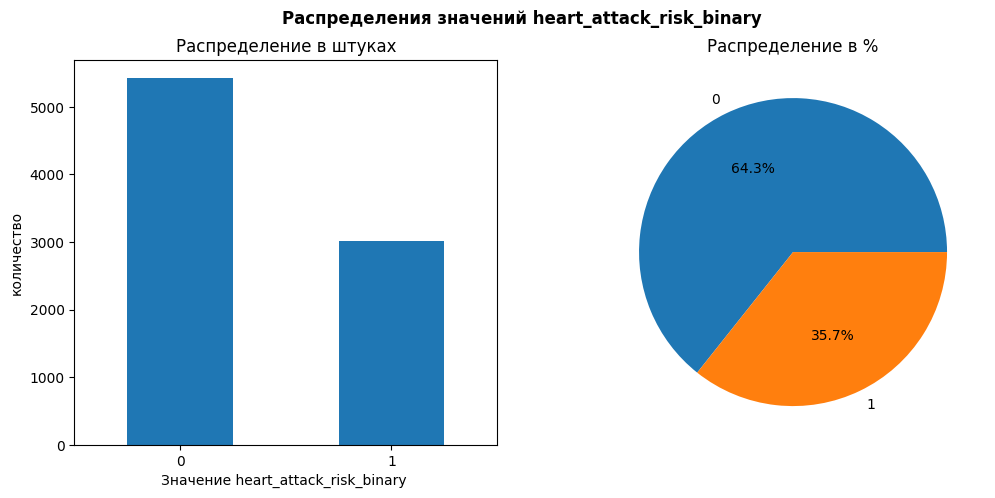


Описательная статистика heart_attack_risk_binary:
count   8_442.0000
mean        0.3569
std         0.4791
min         0.0000
25%         0.0000
50%         0.0000
75%         1.0000
max         1.0000
Name: heart_attack_risk_binary, dtype: float64


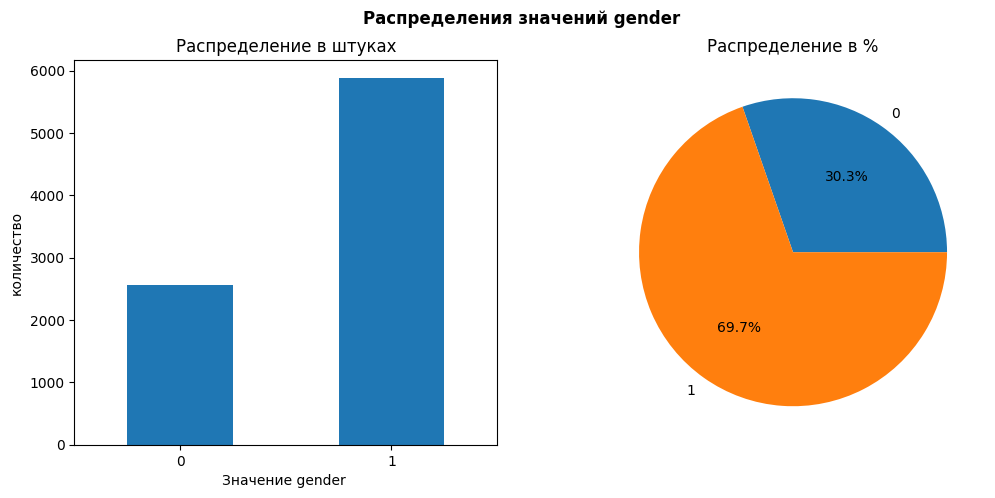


Описательная статистика gender:
count   8_442.0000
mean        0.6968
std         0.4597
min         0.0000
25%         0.0000
50%         1.0000
75%         1.0000
max         1.0000
Name: gender, dtype: float64


In [45]:
for column in cat_columns:
    plot_bar_pie(df_clean[column])

В ходе исследовательского анализа данных установленно, что 2.8% данных в обучающем датасете отличаются по масштабу и набору признаков. Эти данные вносят всплески в непрерывные числовые признаки и неопределенность в категориальные признаки. Скорее всего они присоеденены из другого источника.

### Корреляционный анализ

Проведем корреляционный анализ признаков. Построим матрицу корредяций по всем(колличественным и категориальным) признакам для этого будем использовать phik_matrix из библиотеки phik

In [46]:
interval_cols = [
    'age',
    'cholesterol',
    'heart_rate',
    'exercise_hours_per_week',
    'sedentary_hours_per_day',
    'income',
    'bmi',
    'triglycerides',
    'blood_sugar',
    'ckmb',
    'troponin',
    'systolic_blood_pressure',
    'diastolic_blood_pressure' 
]

In [47]:
phik_overview = phik_matrix(df_full, interval_cols=interval_cols) 
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Blues',
    title=r'correlation $\phi_K$ df_full датасет',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

NameError: name 'phik_matrix' is not defined

В датасете с полными данными можем видеть мультиколениарность среди признаков medication_use, previous_heart_problems, alcohol_consumption, obesity, smoking, diabetes, family_history

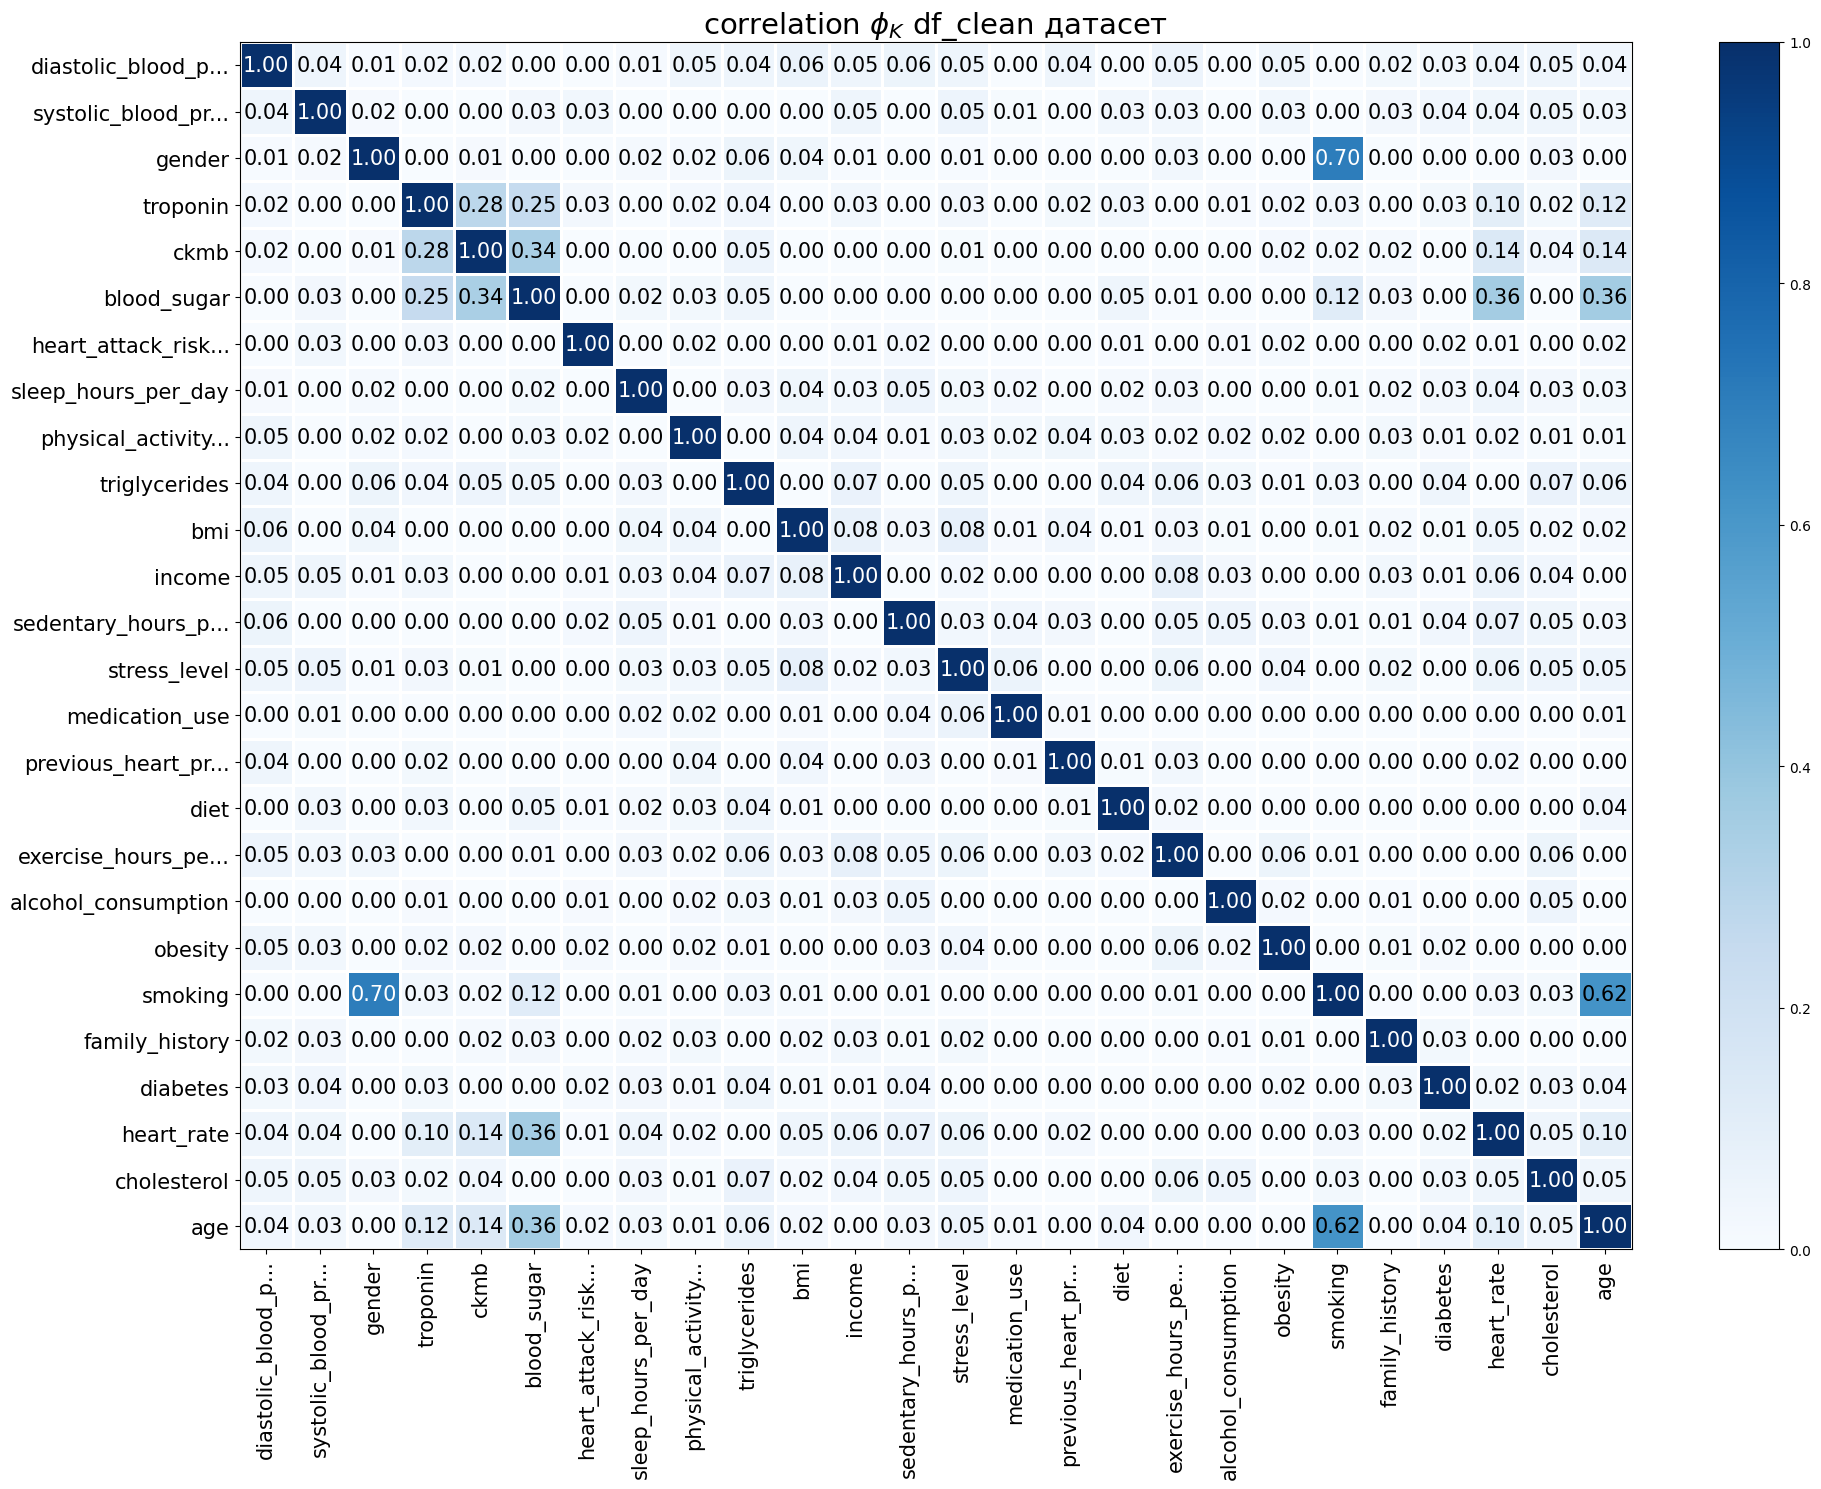

In [ ]:
phik_overview = phik_matrix(df_clean, interval_cols=interval_cols) 
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Blues',
    title=r'correlation $\phi_K$ df_clean датасет',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

В очищенном датасете мультиколинеарности не обнаружино. 

In [ ]:
df_short = df_short.dropna(axis=1)

/home/starostinmv/.conda/envs/starostinmv_py310/lib/python3.10/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable cholesterol for analysis 1. Dropping this column
  warnings.warn(
/home/starostinmv/.conda/envs/starostinmv_py310/lib/python3.10/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable exercise_hours_per_week for analysis 1. Dropping this column
  warnings.warn(
/home/starostinmv/.conda/envs/starostinmv_py310/lib/python3.10/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable sedentary_hours_per_day for analysis 1. Dropping this column
  warnings.warn(
/home/starostinmv/.conda/envs/starostinmv_py310/lib/python3.10/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable income for analysis 1. Dropping this column
  warnings.warn(
/home/starostinmv/.conda/envs/starostinmv_py310/lib/python3.10/site-packages/phik/data_quality.py:72: UserWar

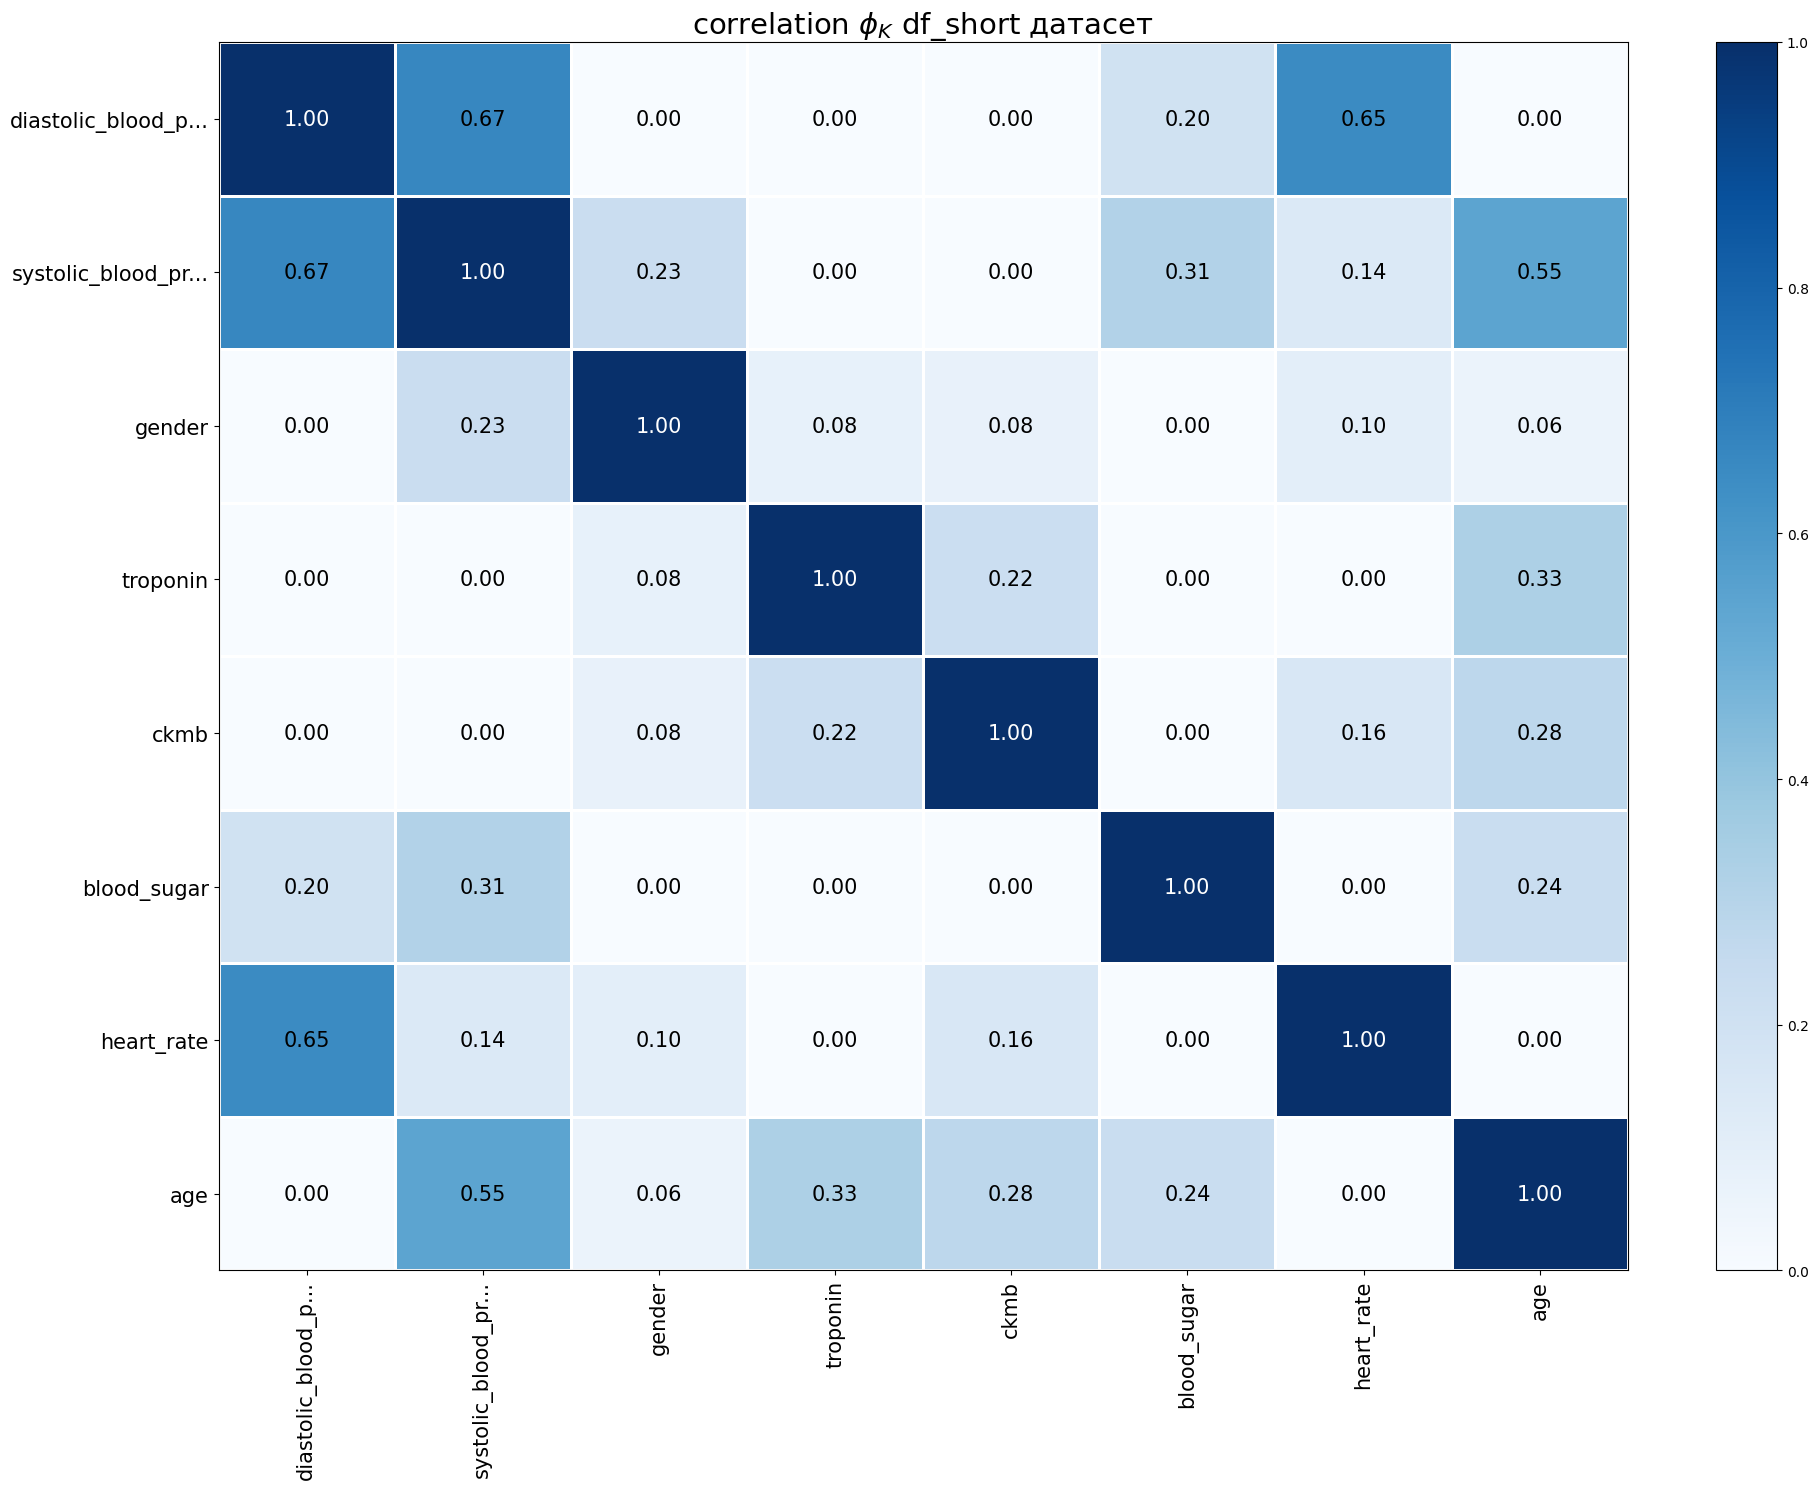

In [ ]:
phik_overview = phik_matrix(df_short, interval_cols=interval_cols) 
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Blues',
    title=r'correlation $\phi_K$ df_short датасет',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

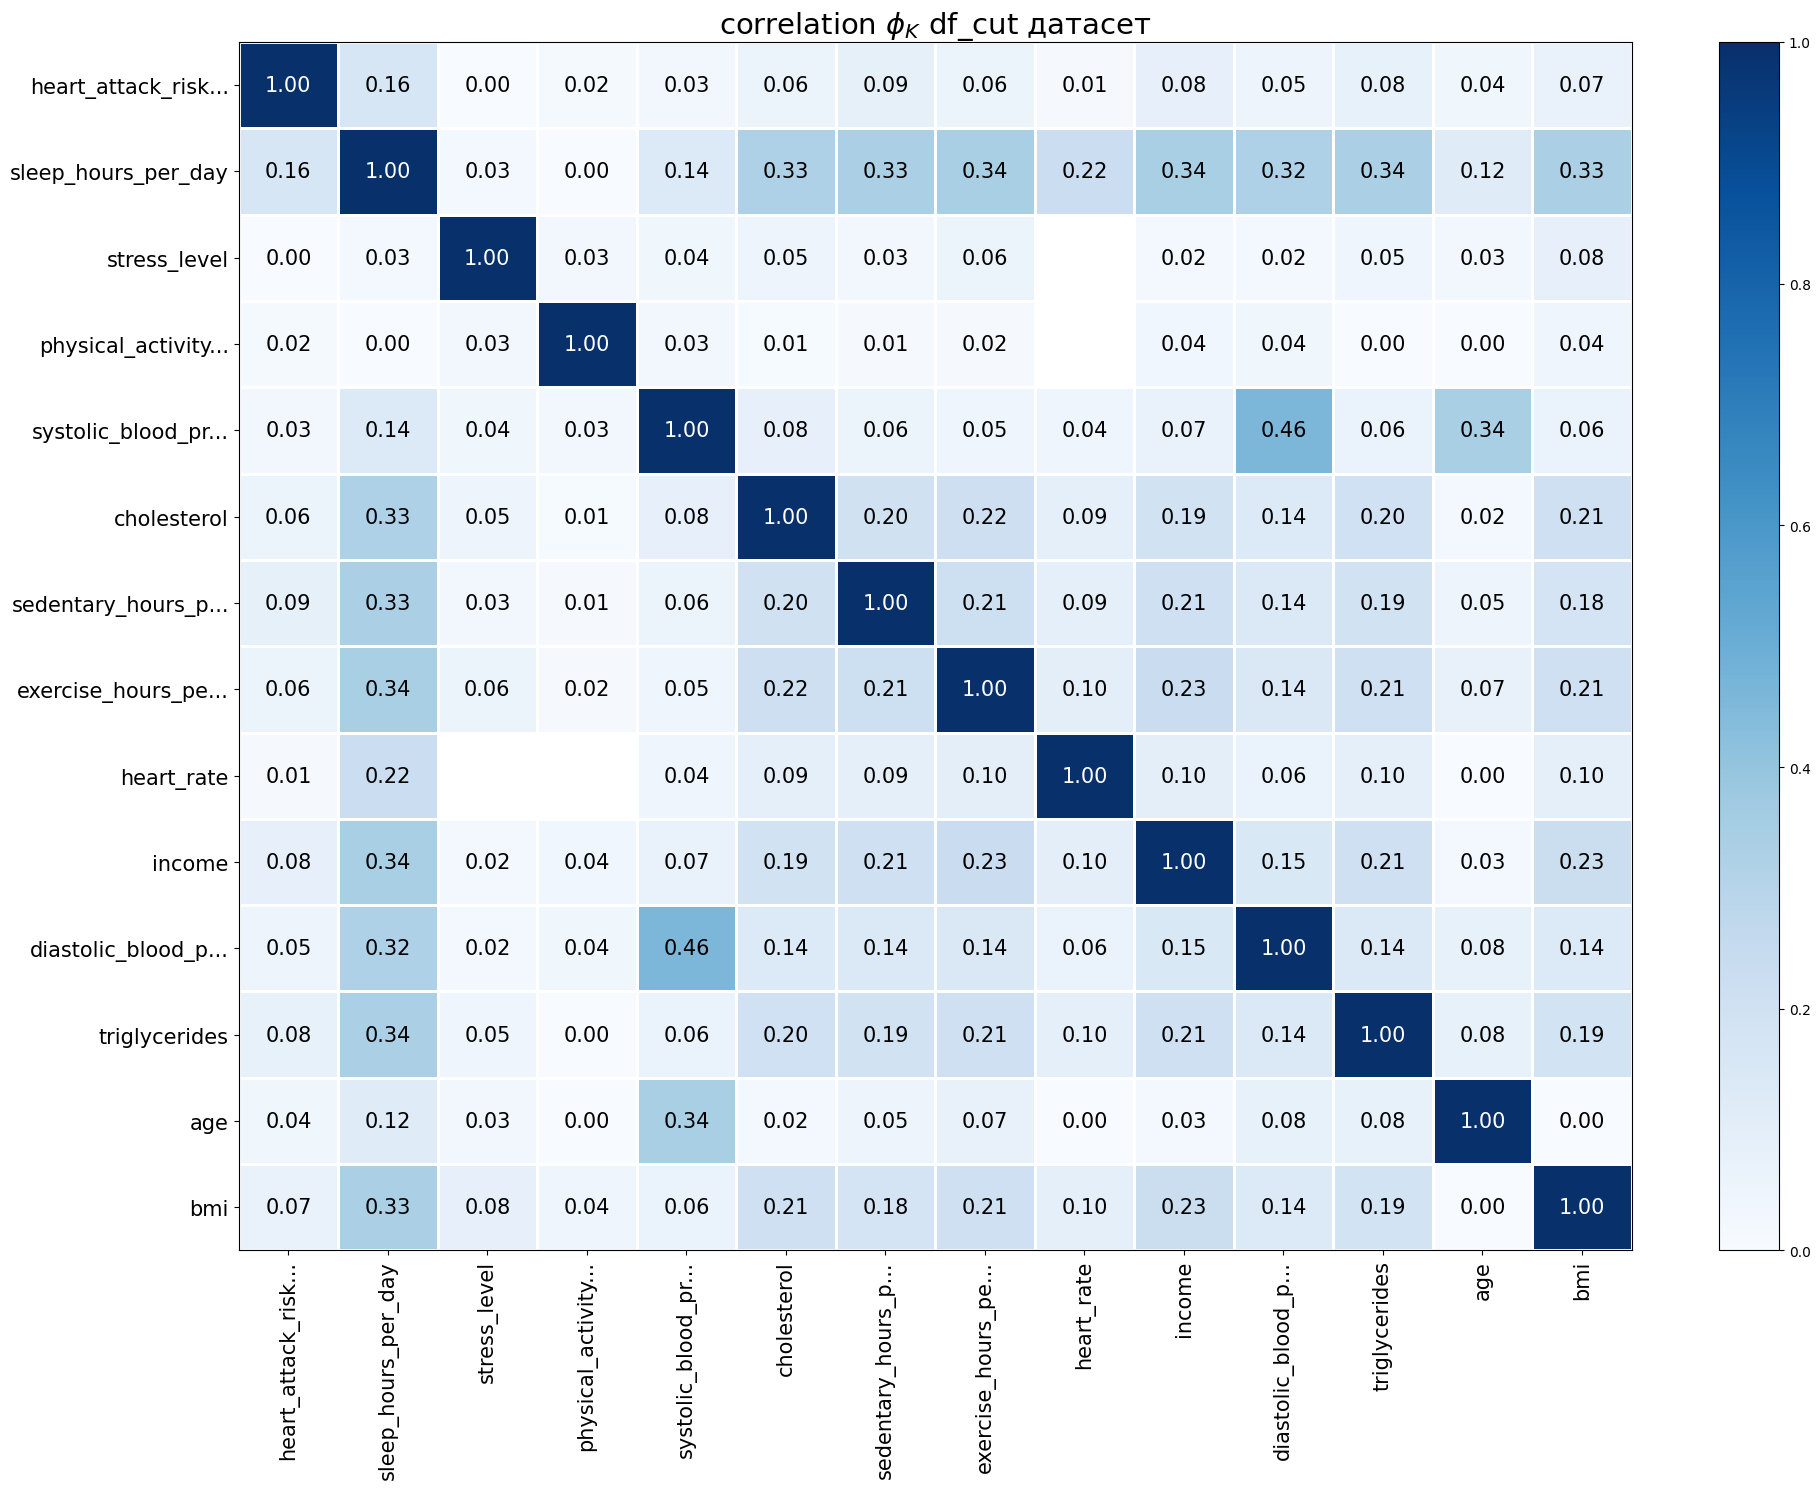

In [ ]:
phik_overview = phik_matrix(df_cut, interval_cols=interval_cols) 
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Blues',
    title=r'correlation $\phi_K$ df_cut датасет',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

В ходе корреляционного анализа установлено, что:
- данные из "другого источника" оказывают  существенное влияние на коэффициенты корреляции, учитывая их иной масштаб
- не обраружина связь между целевым признаком и данными из "другого источника"

Можно сделать вывод, что данные из "другого источника" засоряют наш датасет и их не стоим использвать при обучении модели. При это мы понимаем и принимаем что при равномерном распределении на тренеровочную и тестовую выборки верных предсказаний будет на 2.8% меньше.

Если обучать модель на полных данных, потребуется удалить часть важных признаков по которым выявлена мультиколинеарность. 

## Обучение и проверка моделей

### Выбор метрики

Перед моделью стоит задача определить риск сердечных сзболеваний, при этом не уточнено, имеет ли большую важность найти всех пациентов кто хоть как-то подвержен риску т.е. свести к минимуму ложно положительную ошибку, будем считать, что важность пложительных и отрицательных предсказаний одинаковая. Ктоме того у нас на лицо не сбалансированность данных и наличие выбросов.
Принемая во внимание вышесказанное остановим свой выбор на метрике ROC-AUC.

### Подготовка данных

Подготовку признаков выполним в пайплайне, дополнив пайплайн шагом предобработки. 

In [ ]:
def create_pipeline(X_train, X_test, y_train, y_test,
                  ohe_columns=None,
                  ord_columns=None,
                  categories=[]
                 ):
    '''
    Функция создания пайплайна. Принимает разделенные на тренеровочную и
    тестовую выборки, опиционально: 
    - список колонок для OHE кодировария,
    - список колонок для ORD кодирование,
    - список категориальных признаков.
    Возвращает подготовленный пайплай
    '''
    transformers = []
    # создаём списки с названиями признаков
    num_columns = X_train.select_dtypes(include='number').columns.tolist()
    transformers.append(('num', MinMaxScaler(), num_columns))
    # создаём пайплайн для подготовки признаков из списка ohe_columns: 
    #заполнение пропусков и OHE-кодирование
    # SimpleImputer + OHE
    if ohe_columns:
        ohe_pipe = Pipeline(
            [('simple_imputer_ohe', SimpleImputer(missing_values=np.nan,
                                                  strategy='most_frequent')),
             ('ohe', OneHotEncoder(drop='first',
                                   handle_unknown='ignore',
                                   sparse_output=False))
            ]
            )
        transformers.append(('ohe', ohe_pipe, ohe_columns))
    # создаём пайплайн для подготовки признаков из списка ord_columns: 
    # заполнение пропусков и Ordinal-кодирование
    # SimpleImputer + OE
    if ord_columns:
        ord_pipe = Pipeline(
            [('simple_imputer_before_ord', SimpleImputer(
                missing_values=np.nan, strategy='most_frequent')
             ),
             ('ord',  OrdinalEncoder(
                        categories=categories, 
                        handle_unknown='use_encoded_value',
                        unknown_value=np.nan
                    )
             ),
             ('simple_imputer_after_ord', SimpleImputer(
                 missing_values=np.nan,
                 strategy='most_frequent')
             )
            ]
        )
        transformers.append(('ord', ord_pipe, ord_columns))    
    # создаём объедененный пайплайн для подготовки данных ColumnTransformer
    data_preprocessor = ColumnTransformer(
        transformers, 
        remainder='passthrough'
    )
    # создаём базовый пайплайн: подготовка данных и модель
    pipeline = Pipeline([
        ('preprocessor', data_preprocessor),
        ('models', LogisticRegression())
    ])
    return pipeline

In [ ]:
def split_data(df, 
               target_attr,
               random_state=RANDOM_STATE,
               test_size=TEST_SIZE):
    '''
    Принемает датафрейм, целевой признак, random_state, test_size
    возвращает разделенный на тренеровочную и тестовую выборки.
    '''

    # делим данные на входные и целевые
    X = df.drop([target_attr], axis=1)
    y = df[target_attr]
    # делим данные на тренировочные и тестовые
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )
    return X_train, X_test, y_train, y_test

In [ ]:
# Собираем датафреймы в словарь ключи - имена датафреймов
df_to_fit = {
    'df_full': df_full,
    'df_clean': df_clean,
    'df_cut': df_cut
}

In [ ]:
# Целевой признак
target_attr = 'heart_attack_risk_binary'

#Создаем пустые словари
pipelines = {}
X_trains = {}
X_tests = {}
y_trains = {}
y_tests = {}
#Заполняем их в цикле
for name, df in df_to_fit.items():
    X_trains[name], X_tests[name], y_trains[name], y_tests[name] = (
        split_data(df, target_attr))
    X_trains[name] = df.drop([target_attr], axis=1)
    y_trains[name] = df[target_attr]
    pipelines[name] = create_pipeline(
        X_trains[name], X_tests[name], y_trains[name], y_tests[name])

### Обучение моделей, выбор лучшей модели

### Обучение моделей

Обучим модели. В качестве базовых моделей будем использовать LinearRegression, DecisionTreeClassifier, KNeighborsClassifier, SVC. Альтернативная им модель CatBoostClassifier

Выберим лучшую модель и проверим её качество на основе метрики ROC-AUC

In [ ]:
# Создаем список словарей с параметрами моделей для param_distributions
param_distributions = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 24),
        'models__max_features': range(2, 24),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
        )],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'models__degree': range(3, 8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
]

In [ ]:
param_distributions_cat = [
    {
        'models': [CatBoostClassifier(
            random_state=RANDOM_STATE,
            loss_function='Logloss',
            verbose=False
        )],
        'models__depth': [8, 10],
        'models__iterations': [100, 500],
        'models__learning_rate': [0.1, 0.5],
        'preprocessor__num': ['passthrough']
    }

]

In [ ]:
# Для каждого датасета подбираем лучшую модель. 
# Сохраняем лучшую модеь, ее параметры, метрику и результаты крос валидации
best_models = {}
models_search = {}
for name, pipeline in pipelines.items():
    models_search[name] = RandomizedSearchCV(
        pipeline, 
        param_distributions, 
        cv=5,
        scoring='roc_auc',
        n_iter=30,
        n_jobs=-1,
    )
    models_search[name].fit(X_trains[name], y_trains[name])
    best_params = models_search[name].best_params_
    best_score = models_search[name].best_score_
    best_estimator = models_search[name].best_estimator_
    best_cv_results = models_search[name].cv_results_
    best_models[name] = {
        'best_params': best_params,
        'best_score': best_score,
        'best_estimator': best_estimator,
        'best_cv_results': best_cv_results
    }

Выбор модели CatBoost запустим в отдельном пайплайне

In [ ]:
# Для каждого датасета подбираем лучшую модель СatBoost(). 
# Сохраняем лучшую модеь, ее параметры, метрику и результаты крос валидации
# Функция для обработки каждой модели
def fit_model(name, pipeline, X, y, param_distributions):
    try:
        # Создаем и обучаем GridSearchCV
        grid_search = GridSearchCV(
            pipeline, 
            param_distributions, 
            cv=5,
            scoring='roc_auc',
            n_jobs=int(multiprocessing.cpu_count()/2)  # Ограничиваем количество процессов
        )
        grid_search.fit(X, y)
        
        # Собираем результаты
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        best_estimator = grid_search.best_estimator_
        best_cv_results = grid_search.cv_results_
        
        return {
            'name': name,
            'best_params': best_params,
            'best_score': best_score,
            'best_estimator': best_estimator,
            'best_cv_results': best_cv_results
        }
    finally:
        gc.collect()  # Очищаем память

# Параллельная обработка моделей
best_models_cat = {}
models_search_cat = {}

# Используем Parallel для параллельного выполнения
results = Parallel(
    n_jobs=int(multiprocessing.cpu_count()/2),  # Ограничиваем количество процессов
    max_nbytes=1e6,
    temp_folder='/tmp',
    prefer='processes'
)(
    delayed(fit_model)(
        name, 
        pipeline, 
        X_trains[name], 
        y_trains[name], 
        param_distributions_cat
    )
    for name, pipeline in pipelines.items()
)

# Собираем результаты
for result in results:
    best_models_cat[result['name']] = {
        'best_params': result['best_params'],
        'best_score': result['best_score'],
        'best_estimator': result['best_estimator'],
        'best_cv_results': result['best_cv_results']
    }

In [ ]:
# Для каждого датасета выводим лучшую модель, ее параметры, метрику,
# и результаты крос валидации
for name, best_model in best_models.items():
    print(f'Лучшая модель для {name} и её параметры: '
          f'{best_model["best_params"]} \n')
    print(f'Метрика лучшей модели на тренировочной выборке:'
          f'{best_model["best_score"]:.4f} \n')
    df_results = pd.DataFrame(best_model['best_cv_results'])
    display(df_results.sort_values('rank_test_score').head())

Лучшая модель для df_full и её параметры: {'preprocessor__num': StandardScaler(), 'models__max_features': 10, 'models__max_depth': 17, 'models': DecisionTreeClassifier(random_state=42)} 

Метрика лучшей модели на тренировочной выборке:0.5547 



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__max_features,param_models__max_depth,param_models,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
19,0.0806,0.0040,0.0085,0.0008,StandardScaler(),10,17,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': StandardScaler(), 'models__max_features': 10, 'models__max_depth': 17, 'models': DecisionTreeClassifier(random_state=42)}",0.5688,0.5445,0.5632,0.5596,0.5373,0.5547,0.0119,1
22,0.0277,0.0028,0.0082,0.0021,StandardScaler(),2,16,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': StandardScaler(), 'models__max_features': 2, 'models__max_depth': 16, 'models': DecisionTreeClassifier(random_state=42)}",0.5381,0.5347,0.5548,0.5649,0.5509,0.5487,0.0111,2
23,0.0678,0.0057,0.0071,0.0014,MinMaxScaler(),13,11,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 13, 'models__max_depth': 11, 'models': DecisionTreeClassifier(random_state=42)}",0.5480,0.5382,0.5389,0.5545,0.5396,0.5438,0.0064,3
18,0.1658,0.0008,0.0086,0.0042,StandardScaler(),23,19,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': StandardScaler(), 'models__max_features': 23, 'models__max_depth': 19, 'models': DecisionTreeClassifier(random_state=42)}",0.5294,0.5454,0.5642,0.5485,0.5301,0.5435,0.0129,4
25,0.1017,0.0058,0.0077,0.0011,MinMaxScaler(),14,17,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 14, 'models__max_depth': 17, 'models': DecisionTreeClassifier(random_state=42)}",0.5373,0.5364,0.5576,0.5460,0.5377,0.5430,0.0081,5


Лучшая модель для df_clean и её параметры: {'preprocessor__num': MinMaxScaler(), 'models__max_features': 18, 'models__max_depth': 17, 'models': DecisionTreeClassifier(random_state=42)} 

Метрика лучшей модели на тренировочной выборке:0.5384 



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__max_features,param_models__max_depth,param_models,param_models__kernel,param_models__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.1093,0.0047,0.0074,0.0009,MinMaxScaler(),18.0000,17.0000,DecisionTreeClassifier(random_state=42),NaN,NaN,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 18, 'models__max_depth': 17, 'models': DecisionTreeClassifier(random_state=42)}",0.5479,0.5297,0.5393,0.5360,0.5389,0.5384,0.0059,1
12,0.1054,0.0088,0.0072,0.0016,MinMaxScaler(),15.0000,21.0000,DecisionTreeClassifier(random_state=42),NaN,NaN,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 15, 'models__max_depth': 21, 'models': DecisionTreeClassifier(random_state=42)}",0.5388,0.5390,0.5433,0.5204,0.5408,0.5364,0.0082,2
22,0.0799,0.0034,0.0077,0.0014,MinMaxScaler(),10.0000,19.0000,DecisionTreeClassifier(random_state=42),NaN,NaN,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 10, 'models__max_depth': 19, 'models': DecisionTreeClassifier(random_state=42)}",0.5267,0.5504,0.5399,0.5416,0.5198,0.5357,0.0110,3
8,0.0887,0.0029,0.0071,0.0018,StandardScaler(),12.0000,23.0000,DecisionTreeClassifier(random_state=42),NaN,NaN,"{'preprocessor__num': StandardScaler(), 'models__max_features': 12, 'models__max_depth': 23, 'models': DecisionTreeClassifier(random_state=42)}",0.5653,0.5309,0.5320,0.5139,0.5303,0.5345,0.0168,4
13,0.0280,0.0049,0.0059,0.0011,passthrough,3.0000,19.0000,DecisionTreeClassifier(random_state=42),NaN,NaN,"{'preprocessor__num': 'passthrough', 'models__max_features': 3, 'models__max_depth': 19, 'models': DecisionTreeClassifier(random_state=42)}",0.5268,0.5347,0.5357,0.5304,0.5353,0.5326,0.0034,5


Лучшая модель для df_cut и её параметры: {'preprocessor__num': MinMaxScaler(), 'models__max_features': 8, 'models__max_depth': 17, 'models': DecisionTreeClassifier(random_state=42)} 

Метрика лучшей модели на тренировочной выборке:0.5542 



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__max_features,param_models__max_depth,param_models,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
26,0.0818,0.0023,0.0062,0.0009,MinMaxScaler(),8,17,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 8, 'models__max_depth': 17, 'models': DecisionTreeClassifier(random_state=42)}",0.5403,0.5528,0.5619,0.5581,0.5577,0.5542,0.0075,1
4,0.0973,0.0028,0.0047,0.0011,passthrough,11,14,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': 'passthrough', 'models__max_features': 11, 'models__max_depth': 14, 'models': DecisionTreeClassifier(random_state=42)}",0.5583,0.5175,0.5603,0.5713,0.5487,0.5512,0.0183,2
5,0.0783,0.0037,0.0056,0.0021,passthrough,6,23,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': 'passthrough', 'models__max_features': 6, 'models__max_depth': 23, 'models': DecisionTreeClassifier(random_state=42)}",0.5416,0.5465,0.5727,0.5595,0.5340,0.5508,0.0137,3
19,0.1018,0.0021,0.0051,0.0012,passthrough,9,20,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': 'passthrough', 'models__max_features': 9, 'models__max_depth': 20, 'models': DecisionTreeClassifier(random_state=42)}",0.5484,0.5323,0.5478,0.5695,0.5545,0.5505,0.0120,4
29,0.1131,0.0039,0.0049,0.0010,passthrough,20,15,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': 'passthrough', 'models__max_features': 20, 'models__max_depth': 15, 'models': DecisionTreeClassifier(random_state=42)}",0.5459,0.5424,0.5618,0.5484,0.5487,0.5495,0.0066,5


In [ ]:
# Для каждого датасета выводим лучшую модель CatBoost, ее параметры, метрику,
# и результаты крос валидации
for name, best_model in best_models_cat.items():
    print(f'Лучшая модель для {name} и её параметры: '
          f'{best_model["best_params"]} \n')
    print(f'Метрика лучшей модели на тренировочной выборке:'
          f'{best_model["best_score"]:.4f} \n')
    df_results = pd.DataFrame(best_model['best_cv_results'])
    display(df_results.sort_values('rank_test_score').head())

Лучшая модель для df_full и её параметры: {'models': <catboost.core.CatBoostClassifier object at 0x7f0c53d0f520>, 'models__depth': 10, 'models__iterations': 500, 'models__learning_rate': 0.1, 'preprocessor__num': 'passthrough'} 

Метрика лучшей модели на тренировочной выборке:0.5937 



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__depth,param_models__iterations,param_models__learning_rate,param_preprocessor__num,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,64.2999,1.4031,0.1457,0.0776,<catboost.core.CatBoostClassifier object at 0x7f0c53d0f520>,10,500,0.1000,passthrough,"{'models': <catboost.core.CatBoostClassifier object at 0x7f0c53d0f520>, 'models__depth': 10, 'models__iterations': 500, 'models__learning_rate': 0.1, 'preprocessor__num': 'passthrough'}",0.5912,0.5853,0.5956,0.6030,0.5932,0.5937,0.0058,1
2,33.3473,1.2578,1.9771,0.8115,<catboost.core.CatBoostClassifier object at 0x7f0c53d0f520>,8,500,0.1000,passthrough,"{'models': <catboost.core.CatBoostClassifier object at 0x7f0c53d0f520>, 'models__depth': 8, 'models__iterations': 500, 'models__learning_rate': 0.1, 'preprocessor__num': 'passthrough'}",0.5892,0.5737,0.6155,0.5922,0.5879,0.5917,0.0135,2
7,62.9470,0.3979,0.1079,0.0433,<catboost.core.CatBoostClassifier object at 0x7f0c53d0f520>,10,500,0.5000,passthrough,"{'models': <catboost.core.CatBoostClassifier object at 0x7f0c53d0f520>, 'models__depth': 10, 'models__iterations': 500, 'models__learning_rate': 0.5, 'preprocessor__num': 'passthrough'}",0.5986,0.5755,0.5892,0.6055,0.5855,0.5909,0.0104,3
3,33.3254,1.0240,1.5817,1.1162,<catboost.core.CatBoostClassifier object at 0x7f0c53d0f520>,8,500,0.5000,passthrough,"{'models': <catboost.core.CatBoostClassifier object at 0x7f0c53d0f520>, 'models__depth': 8, 'models__iterations': 500, 'models__learning_rate': 0.5, 'preprocessor__num': 'passthrough'}",0.5765,0.5717,0.6126,0.5904,0.6009,0.5904,0.0151,4
5,28.9503,1.7573,2.0366,1.2877,<catboost.core.CatBoostClassifier object at 0x7f0c53d0f520>,10,100,0.5000,passthrough,"{'models': <catboost.core.CatBoostClassifier object at 0x7f0c53d0f520>, 'models__depth': 10, 'models__iterations': 100, 'models__learning_rate': 0.5, 'preprocessor__num': 'passthrough'}",0.5987,0.5774,0.5801,0.5966,0.5738,0.5853,0.0103,5


Лучшая модель для df_clean и её параметры: {'models': <catboost.core.CatBoostClassifier object at 0x7f0c53eaada0>, 'models__depth': 10, 'models__iterations': 500, 'models__learning_rate': 0.1, 'preprocessor__num': 'passthrough'} 

Метрика лучшей модели на тренировочной выборке:0.5857 



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__depth,param_models__iterations,param_models__learning_rate,param_preprocessor__num,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,66.1311,0.6389,0.1185,0.0565,<catboost.core.CatBoostClassifier object at 0x7f0c53eaada0>,10,500,0.1000,passthrough,"{'models': <catboost.core.CatBoostClassifier object at 0x7f0c53eaada0>, 'models__depth': 10, 'models__iterations': 500, 'models__learning_rate': 0.1, 'preprocessor__num': 'passthrough'}",0.5757,0.5774,0.5999,0.5876,0.5877,0.5857,0.0087,1
7,64.0991,0.8591,0.0673,0.0306,<catboost.core.CatBoostClassifier object at 0x7f0c53eaada0>,10,500,0.5000,passthrough,"{'models': <catboost.core.CatBoostClassifier object at 0x7f0c53eaada0>, 'models__depth': 10, 'models__iterations': 500, 'models__learning_rate': 0.5, 'preprocessor__num': 'passthrough'}",0.5713,0.5790,0.5781,0.5833,0.5759,0.5775,0.0039,2
4,29.4524,1.8845,0.7420,0.2420,<catboost.core.CatBoostClassifier object at 0x7f0c53eaada0>,10,100,0.1000,passthrough,"{'models': <catboost.core.CatBoostClassifier object at 0x7f0c53eaada0>, 'models__depth': 10, 'models__iterations': 100, 'models__learning_rate': 0.1, 'preprocessor__num': 'passthrough'}",0.5562,0.5729,0.5812,0.5801,0.5916,0.5764,0.0117,3
5,27.5316,1.5145,0.9387,0.8403,<catboost.core.CatBoostClassifier object at 0x7f0c53eaada0>,10,100,0.5000,passthrough,"{'models': <catboost.core.CatBoostClassifier object at 0x7f0c53eaada0>, 'models__depth': 10, 'models__iterations': 100, 'models__learning_rate': 0.5, 'preprocessor__num': 'passthrough'}",0.5637,0.5786,0.5704,0.5817,0.5727,0.5734,0.0063,4
3,33.7050,1.0641,1.4440,0.4912,<catboost.core.CatBoostClassifier object at 0x7f0c53eaada0>,8,500,0.5000,passthrough,"{'models': <catboost.core.CatBoostClassifier object at 0x7f0c53eaada0>, 'models__depth': 8, 'models__iterations': 500, 'models__learning_rate': 0.5, 'preprocessor__num': 'passthrough'}",0.5724,0.5572,0.5838,0.5757,0.5770,0.5732,0.0088,5


Лучшая модель для df_cut и её параметры: {'models': <catboost.core.CatBoostClassifier object at 0x7f0c53d0d6c0>, 'models__depth': 10, 'models__iterations': 500, 'models__learning_rate': 0.1, 'preprocessor__num': 'passthrough'} 

Метрика лучшей модели на тренировочной выборке:0.6004 



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__depth,param_models__iterations,param_models__learning_rate,param_preprocessor__num,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,58.3436,0.8189,0.1227,0.0743,<catboost.core.CatBoostClassifier object at 0x7f0c53d0d6c0>,10,500,0.1000,passthrough,"{'models': <catboost.core.CatBoostClassifier object at 0x7f0c53d0d6c0>, 'models__depth': 10, 'models__iterations': 500, 'models__learning_rate': 0.1, 'preprocessor__num': 'passthrough'}",0.6070,0.5924,0.6075,0.6014,0.5935,0.6004,0.0064,1
7,56.2064,0.9198,0.1415,0.0746,<catboost.core.CatBoostClassifier object at 0x7f0c53d0d6c0>,10,500,0.5000,passthrough,"{'models': <catboost.core.CatBoostClassifier object at 0x7f0c53d0d6c0>, 'models__depth': 10, 'models__iterations': 500, 'models__learning_rate': 0.5, 'preprocessor__num': 'passthrough'}",0.6084,0.5832,0.5997,0.6013,0.5963,0.5978,0.0083,2
2,28.6097,0.7862,0.6382,0.2913,<catboost.core.CatBoostClassifier object at 0x7f0c53d0d6c0>,8,500,0.1000,passthrough,"{'models': <catboost.core.CatBoostClassifier object at 0x7f0c53d0d6c0>, 'models__depth': 8, 'models__iterations': 500, 'models__learning_rate': 0.1, 'preprocessor__num': 'passthrough'}",0.6020,0.5911,0.6133,0.5863,0.5862,0.5958,0.0105,3
3,28.8826,0.9994,0.7543,0.3034,<catboost.core.CatBoostClassifier object at 0x7f0c53d0d6c0>,8,500,0.5000,passthrough,"{'models': <catboost.core.CatBoostClassifier object at 0x7f0c53d0d6c0>, 'models__depth': 8, 'models__iterations': 500, 'models__learning_rate': 0.5, 'preprocessor__num': 'passthrough'}",0.6026,0.5704,0.6173,0.6040,0.5843,0.5957,0.0165,4
5,23.7096,3.6493,0.5392,0.2642,<catboost.core.CatBoostClassifier object at 0x7f0c53d0d6c0>,10,100,0.5000,passthrough,"{'models': <catboost.core.CatBoostClassifier object at 0x7f0c53d0d6c0>, 'models__depth': 10, 'models__iterations': 100, 'models__learning_rate': 0.5, 'preprocessor__num': 'passthrough'}",0.5893,0.5697,0.6019,0.5831,0.5801,0.5848,0.0106,5


Лучшая модель для df_cut и её параметры: {'models': <catboost.core.CatBoostClassifier object at 0x7fc9fde14280>, 'models__depth': 10, 'models__iterations': 500, 'models__learning_rate': 0.1, 'preprocessor__num': 'passthrough'} 

Метрика лучшей модели на тренировочной выборке:0.6004 

Эту модель будем использовать в приложении.

### Предсказания на тестовой выборке

In [ ]:
# Тесовый датафрейм с преобразованием имен столбцов
X_test = to_snake_case(df_heart_test)
# Cохраняем id для последующего объедениения с предсказаниями
X_test_id = X_test['id']
# Оставляем только нужные столбцы
X_test = X_test[[
    'bmi',
    'age',
    'triglycerides',
    'diastolic_blood_pressure',
    'income',
    'heart_rate',
    'exercise_hours_per_week',
    'sedentary_hours_per_day',
    'cholesterol',
    'systolic_blood_pressure',
    'physical_activity_days_per_week',
    'stress_level',
    'sleep_hours_per_day'
]]

In [ ]:
# Извлекаем модель из словаря
model = best_models_cat['df_cut']
# Получение препроцессора из пайплайна
preprocessor = model['best_estimator'].named_steps[
        'preprocessor']
# Подготовка данных X_test_preproc  
X_test_preproc = preprocessor.transform(
        X_test)

In [ ]:
# Получение модели из пайплайна
best_estimator = model['best_estimator'].named_steps['models'] 
# Предсказания 
y_prediction = best_estimator.predict(
    X_test_preproc)

In [ ]:
# Объединение y_predictions и X_test_id
y_prediction = pd.Series(y_prediction)
predictions = pd.concat([
    X_test_id,
    y_prediction
],
    axis=1
)
predictions.columns = ['id','prediction']
predictions['prediction'] = predictions['prediction'].astype(int)

In [ ]:
# Сохранение предсказаний в CSV в папку проекта
try:
    predictions.to_csv('predictions.csv', 
                       index=False,
                       encoding='utf-8',
                       sep=',')
    print("Файл успешно сохранен")
except Exception as e:
    print(f"Ошибка при сохранении файла: {str(e)}")

Файл успешно сохранен


Предсказания на тестовой выборке сохранены в папку проекта в формате CSV в файле predictions.csv

## Анализ важности признаков

CatBoost имеет встроенную оценку важности признаков будем использовать ее

In [ ]:
# Извлекаем признаки из модели
importances = best_estimator.get_feature_importance(prettified=True)
importances.columns = ['id', 'importances']
importances['id'] = pd.to_numeric(importances['id'])
importances = importances.set_index('id')

# Создадим датафрейм с названиями признаков
features = pd.DataFrame(X_test.columns)
features.columns = ['feature']

# Объединяем по индексу
features_importance = features.join(importances).sort_values(
    by='importances', ascending=False)

features_importance

,feature,importances
0,bmi,8.4549
6,exercise_hours_per_week,8.4189
2,triglycerides,8.3425
4,income,8.1872
7,sedentary_hours_per_day,8.1683
3,diastolic_blood_pressure,8.0365
8,cholesterol,8.0252
1,age,7.8284
9,systolic_blood_pressure,7.6126
5,heart_rate,7.2435


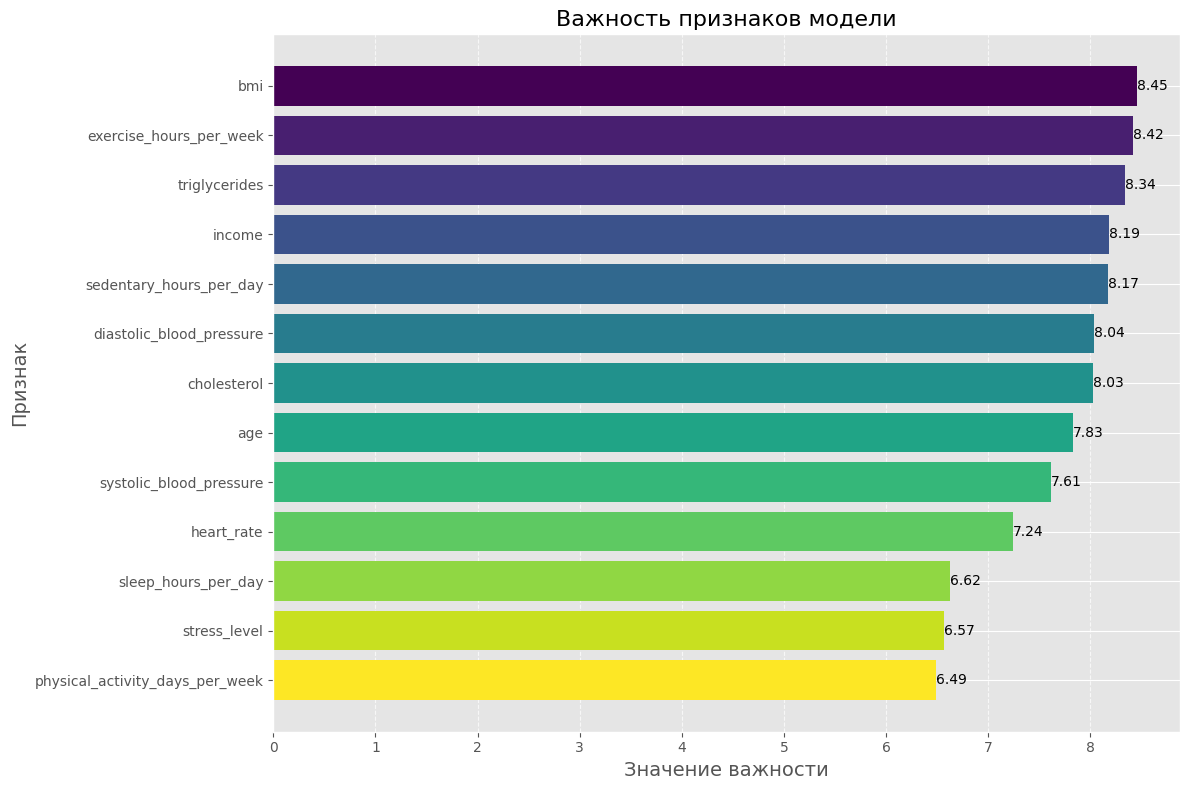

In [ ]:
plt.figure(figsize=(12, 8))
plt.style.use('ggplot')

# Создаем график через matplotlib
bars = plt.barh(
 features_importance['feature'], 
 features_importance['importances'], 
 color=plt.cm.viridis(np.linspace(0, 1, len(features_importance)))
)

# Настройка заголовка и подписей
plt.title('Важность признаков модели', fontsize=16)
plt.xlabel('Значение важности', fontsize=14)
plt.ylabel('Признак', fontsize=14)

# Добавляем значения важности над столбцами
for i, v in enumerate(features_importance['importances']):
 plt.text(v, i, f'{v:.2f}', 
 color='black', 
 ha='left', 
 va='center', 
 fontsize=10)

plt.gca().invert_yaxis()  # Чтобы важные признаки были сверху
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Признаки с меньшей важностью уалены на предидущей итерации. Удаление признаков улучшило метрику с 0.5937 до 0.6004

## Выводы:

### Обзор данных 

В ходе обзора данных выявлено:
- В датасете имеются  лишние поля `Unnamed: 0` и `id` которые нужны для обучения модели..
- В датасете присутствуют пропуски.
- Часть признаков отмасштабированы, часть нет. 

### Предобработка данных
Предобработка данных показала, что:
- Часть данных в поле gender закодировано, часть нет
- У части пациентов отсутсвуют данные в полях: `diabetes, family_history, smoking, obesity, alcohol_consumption, previous_heart_problems, medication_use, stress_level, physical_activity_days_per_week`. Данные в этих полях закодированы 0 и 1 заполним пропуски значением 2

### Исследовательский анализ данных
В ходе исселдовательского анализа выяснили что:

- 'age' - данные масштабированы
- 'heart_rate' - выброс
- 'diabetes' - категориальный закодированный
- 'family_history' - категориальный закодированный
- 'smoking' - категориальный закодированный
- 'obesity' - категориальный закодированный
- 'alcohol_consumption' - категориальный закодированный
- 'previous_heart_problems' - категориальный закодированный
- 'medication_use' - категориальный закодированный
- 'stress_level' - категориальный закодированный
- 'physical_activity_days_per_week' - категориальный закодированный
- 'heart_attack_risk_binary' - категориальный закодированный целувой признак
- 'gender' категориальный часть данных закодирована

Скорее всего при масштабировании данных не были обработаны выбросы. 
- Использовали модель не чувствительную к вбросам. 
- Строковые занчени gender приведены к 1 и 0
- 2.8% данных в обучающем датасете отличаются по масштабу и набору признаков. Эти данные вносят всплески в непрерывные числовые признаки и неопределенность в категориальные признаки. Скорее всего они присоеденены из другого источника.

### Корреляционный анализ

- Построили матрицы корредяций по всем(колличественным и категориальным) признакам с помощью phik_matrix из библиотеки phik
- В датасете с полными данными df_full можем видеть мультиколениарность среди признаков medication_use, previous_heart_problems, alcohol_consumption, obesity, smoking, diabetes, family_history
- В очищенном датасете df_clean мультиколинеарности не обнаружино. 
- В датасете с ограниченным набором полей df_cut мультиколинеарности не обнаружино. 


В ходе корреляционного анализа установлено, что:
- данные из "другого источника" оказывают  существенное влияние на коэффициенты корреляции, учитывая их иной масштаб
- не обраружина связь между целевым признаком и данными из "другого источника"
- Данные из "другого источника" засоряют датасет, но использование полных даннх дает лушие показатели метртики, поэтоу финальная модель обучается на полных данных/


### Обучение и проверка моделей

#### Выбор метрики
Перед моделью стоит задача определить риск сердечных сзболеваний, при этом не уточнено, имеет ли большую важность найти всех пациентов кто хоть как-то подвержен риску т.е. свести к минимуму ложно положительную ошибку, будем считать, что важность пложительных и отрицательных предсказаний одинаковая. Ктоме того у нас на лицо не сбалансированность данных и наличие выбросов.
Принемая во внимание вышесказанное остановили  выбор на метрике ROC-AUC.

#### Подготовка данных

Подготовка признаков выполнена в пайплайне, пайплайн дополнeн шагом предобработки. 

### Обучение моделей, выбор лучшей модели

Лучшиее значение мертики ROC-AUC достигнуты на датасете df_cut в модели CatBoostClassifier со следующими патаметрами:

Лучшая модель для df_cut и её параметры: `{'models': <catboost.core.CatBoostClassifier object at 0x7fc9fde14280>, 'models__depth': 10, 'models__iterations': 500, 'models__learning_rate': 0.1, 'preprocessor__num': 'passthrough'}` 

Метрика ROC-AUC лучшей модели на тренировочной выборке: 0.6004 

Эту модель будем использовать в приложении.

Предсказания на тестовой выборке сохранены в папку проекта в формате CSV в файле predictions.csv

### Анализ важности признаков

CatBoost имее встроенную оценку важности признаков будем использовать ее

Наибольшеий вес имеют признаки: 
- Признак					- важность
- bmi						- 8.4549
- exercise_hours_per_week	- 8.4189
- triglycerides				- 8.3425
- income					- 8.1872
- sedentary_hours_per_day	- 8.1683
- diastolic_blood_pressure	- 8.0365
- cholesterol				- 8.0252
- age						- 7.8284
- systolic_blood_pressure	- 7.6126
- heart_rate				- 7.2435
- sleep_hours_per_day		- 6.6219
- stress_level				- 6.5700
- physical_activity_days_per_week	- 6.4902

### Полученный результат:

- Разработано приложение на FastAPI которое принимает на вход путь к csv файлу тестовой выборки, выполняет предсказание, путем POST запроса к сервису и возвращает ответ в формате JSON. 

- Проект оформлен в виде репозитория на github

- Сервис снабжен документацией для пользователя и описанием классов и методов

### Рекомендации:
Для улучшения метрики качества предсказаний можно порекоменовать улучшить качестват обучающиъ и соответстенно тестовых данных, а именно:
- Проводить кодирование и масштабирование признаков после того как они будут собранны из различных источников в моделе, чтобы даные были в одном масштабе.
- При сборе данных избегать прорусков в требуемых полях.
- Уменьшить колличество полей, исключив те, которые имеют низкую важность.

После улучшения качества входных данных прилжение можно будет дополнит валидацией входных данных на базе pydantic.